# `Практикум по программированию на языке Python`

## `Задание 03. Рекуррентные Нейронные Сети. Dropout. LM`

#### Фамилия, имя: 

Дата выдачи: <span style="color:red">__03 апреля 04:00__</span>.

Мягкий дедлайн: <span style="color:red">__18 апреля 23:59__</span>.

Стоимость: __10 баллов__ (основная часть заданий) + __7 баллов__ (дополнительные задания).

<span style="color:red">__В ноутбуке все клетки должны выполняться без ошибок при последовательном их выполнении.__</span>

#### `Москва, 2023`

Данное задание будет состоять из двух частей:
1. Применение рекуррентной сети для решения задачи классификации текста. Более конкретно -- предсказания рейтинга отзыва фильма.
2. Простейшая лингвистическая модель для генерации текста на основе LSTM.

При выполнении задания вы обучите LSTM с разным уровнем "коробочности", а также познакомитесь с различными способами применения DropOut к рекуррентным архитектурам. В рекуррентных архитектурах вариантов, куда можно наложить бинарную маску шума, гораздо больше, чем в нейросетях прямого прохода.

Во второй части вы попробуете реализовать простейший рекуррентный декодер для генерации текстов.

Задание сделано так, чтобы его можно было выполнять на CPU, однако RNN - это ресурсоёмкая вещь, поэтому на GPU с ними работать приятнее. Можете попробовать использовать [https://colab.research.google.com](https://colab.research.google.com) - бесплатное облако с GPU.

**Для корректного отображения картинок, вам может понадобится сделать ноутбук доверенным (Trusted) в правом верхнем углу**

# `Часть 0. Загрузка и предобработка данных (1 балл)`

## `Рекомендуемые гиперпараметры`

In [3]:
max_length = 200
top_n_words = 5000

hidden_dim = 128
embedding_dim = 32

num_epochs = 15
batch_size = 64
learning_rate = 1e-3

Первое, что нужно сделать — скачать, предобработать данные и организовать их таким образом, чтобы их можно было подавать в нейронную сеть.

Для обеих частей задания мы будем использовать [**Large Movie Review Dataset**](https://ai.stanford.edu/~amaas/data/sentiment/).

## `Загрузка и предобработка данных`

Загрузите данные по ссылке выше. (**tip**: используйте `wget`)

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
%cd /content/drive/MyDrive/Colab\ Notebooks/dl/task3

/content/drive/MyDrive/Colab Notebooks/dl/task3


In [6]:
!rm -r aclImdb

In [7]:
!wget https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz

--2023-04-19 21:22:24--  https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
Resolving ai.stanford.edu (ai.stanford.edu)... 171.64.68.10
Connecting to ai.stanford.edu (ai.stanford.edu)|171.64.68.10|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 84125825 (80M) [application/x-gzip]
Saving to: ‘aclImdb_v1.tar.gz.2’

aclImdb_v1.tar.gz.2 100%[===================>]  80.23M  54.9MB/s    in 1.5s    

2023-04-19 21:22:26 (54.9 MB/s) - ‘aclImdb_v1.tar.gz.2’ saved [84125825/84125825]



Распакуйте скачанные данные в папку `aclImdb` (**tip:** используйте `tar`)

In [8]:

!tar -xzvf aclImdb_v1.tar.gz

Streaming output truncated to the last 5000 lines.
aclImdb/train/unsup/44983_0.txt
aclImdb/train/unsup/44982_0.txt
aclImdb/train/unsup/44981_0.txt
aclImdb/train/unsup/44980_0.txt
aclImdb/train/unsup/44979_0.txt
aclImdb/train/unsup/44978_0.txt
aclImdb/train/unsup/44977_0.txt
aclImdb/train/unsup/44976_0.txt
aclImdb/train/unsup/44975_0.txt
aclImdb/train/unsup/44974_0.txt
aclImdb/train/unsup/44973_0.txt
aclImdb/train/unsup/44972_0.txt
aclImdb/train/unsup/44971_0.txt
aclImdb/train/unsup/44970_0.txt
aclImdb/train/unsup/44969_0.txt
aclImdb/train/unsup/44968_0.txt
aclImdb/train/unsup/44967_0.txt
aclImdb/train/unsup/44966_0.txt
aclImdb/train/unsup/44965_0.txt
aclImdb/train/unsup/44964_0.txt
aclImdb/train/unsup/44963_0.txt
aclImdb/train/unsup/44962_0.txt
aclImdb/train/unsup/44961_0.txt
aclImdb/train/unsup/44960_0.txt
aclImdb/train/unsup/44959_0.txt
aclImdb/train/unsup/44958_0.txt
aclImdb/train/unsup/44957_0.txt
aclImdb/train/unsup/44956_0.txt
aclImdb/train/unsup/44955_0.txt
aclImdb/train/unsup/4

Посмотрите в файле `./aclImdb/README` как организованы данные:

In [9]:
! cat ./aclImdb/train/pos/10003_8.txt

This is not the typical Mel Brooks film. It was much less slapstick than most of his movies and actually had a plot that was followable. Leslie Ann Warren made the movie, she is such a fantastic, under-rated actress. There were some moments that could have been fleshed out a bit more, and some scenes that could probably have been cut to make the room to do so, but all in all, this is worth the price to rent and see it. The acting was good overall, Brooks himself did a good job without his characteristic speaking to directly to the audience. Again, Warren was the best actor in the movie, but "Fume" and "Sailor" both played their parts well.

In [10]:
test_data_path = './aclImdb/test/'
train_data_path = './aclImdb/train/'

In [11]:
import os
from functools import partial
from collections import defaultdict, OrderedDict

import nltk
nltk.download('stopwords')

import regex
import numpy as np

import torch
import torchtext
from torch.utils.data import Dataset, DataLoader

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Стандартной предобработкой данных является токенизация текстов. Полученные токены можно будет закодировать и затем подавать на вход нейронной сети. Ключевым моментом, который влияет на скорость работы нейросети и её размер в памяти — размер словаря, используемого при токенизации. Для задачи классификации мы можем убрать часть слов (стоп слова, редкие слова), ускорив обучение без потери в качестве.

In [12]:
STOPWORDS = nltk.corpus.stopwords.words('english')

Реализуйте функцию для токенизации текста. Выполнять токенизацию можно по-разному, но в данном задании предлагается это делать следующим образом:
1. Привести текст к нижнему регистру
2. Убрать html разметку из текстов (`<br />`, ...)
3. Убрать все символы кроме латинских букв
4. Разбить строку по пробелам
5. Убрать стоп слова

In [13]:
def tokenize(text):
    """
    :param str text: Input text 
    :return List[str]: List of words
    """
    # YOUR CODE HERE
    text = text.lower()
    text = regex.sub('<br />', '', text)
    text = ''.join(l for l in text if l.isalpha() or l == ' ')
    word_list = text.split()
    return [word for word in word_list if word not in STOPWORDS]

In [14]:
tokenize('1. Hello <br /> words!! <br />')

['hello', 'words']

Теперь мы можем создать словарь, с помощью которого мы будем численно кодировать токены из текста и наоборот.

Удобной обёрткой для создания словарей является класс `torchtext.vocab.Vocab` и фабрика для создания таких классов `torchtext.vocab.vocab`.

In [15]:
torchtext.vocab.vocab??

Чтобы создать такой словарь, сначала нужно создать словарь со всеми токенами в тексте и их частотами встречаемости:

In [16]:
from tqdm import tqdm

In [17]:
counter = defaultdict(int)

for path in ['./aclImdb/test/neg', './aclImdb/test/pos', './aclImdb/train/neg', './aclImdb/train/pos']:
    for file_path in tqdm(os.listdir(path)):
        text = open(os.path.join(path, file_path), 'r', encoding='utf-8', errors='ignore').read().strip()
        for token in tokenize(text):
            counter[token] += 1

100%|██████████| 12500/12500 [00:21<00:00, 580.01it/s]


Для работы с текстами нам необходимо зарезервировать два специальных токена:
1. `<pad>` для токена означающего паддинг
2. `<unk>` для токенов, которые отсутствуют в словаре

In [18]:
specials = ['<pad>', '<unk>']
for special in specials:
    counter[special] = 0

Создайте словарь из словаря частот `counter`. Наименьшие *id* отдайте под специальные токены. 

Отбросьте низкочастотные слова, оставив только `top_n_words` слов. Можете использовать любой способ реализации этого условия, например:
1. Оставить в словаре `counter` нужное число слов
2. Подобрать параметр `min_freq`, чтобы оставшееся число слов было близко к необходимому порогу

In [19]:
from torchtext.vocab import vocab


In [20]:
OrderedDict(sorted(counter.items(), key=lambda x: x[1], reverse=True))['film']


74490

In [21]:
'this' in STOPWORDS

True

In [22]:
# YOUR CODE HERE
v = vocab(
    OrderedDict(sorted(counter.items(), key=lambda x: x[1], reverse=True)[:top_n_words]),
    specials=specials)

In [23]:
v.lookup_indices(['<pad>', '<unk>'])

[0, 1]

In [24]:
v.set_default_index(v['<unk>'])

In [25]:
v.lookup_indices(['this', 'film', 'was', 'awful'])

[1, 3, 1, 272]

Теперь мы готовы создать обёртку-датасет для наших данных. 

Необходимо добавить несколько опции, которые понадобятся во второй части задания:
1. Ограничение на максимальную длину текста в токенах. Если текст оказывается длиннее, то последние токены отбрасываются
2. Возможность добавить в специальные токены `<sos>`, `<eos>` в начало и конец токенизированного текста
    
**tips:**
1. Обратите особое внимание, что у длинных текстов не должен обрезаться паддинг
2. В исходных данных рейтинг закодирован в названии файла в виде числа от $1$ до $10$. Для удобства, вычтите $1$, чтобы рейтинг был от $0$ до $9$

In [26]:
class LargeMovieReviewDataset(Dataset):
    def __init__(self, data_path, vocab, max_len, pad_sos=False, pad_eos=False):
        """
        :param str data_path: Path to folder with one of the data splits (train or test)
        :param torchtext.vocab.Vocab vocab: dictionary with lookup_indices method
        :param int max_len: Maximum length of tokenized text
        :param bool pad_sos: If True pad sequence at the beginning with <sos> 
        :param bool pad_eos: If True pad sequence at the end with <eos>         
        """
        super().__init__()
        
        self.pad_sos = pad_sos
        if self.pad_sos:
            self.sos_id = vocab.lookup_indices(['<sos>'])[0]
        self.pad_eos = pad_eos
        if self.pad_eos:
            self.eos_id = vocab.lookup_indices(['<eos>'])[0]
        
        self.vocab = vocab
        self.max_len = max_len
        self.data_path = data_path
        self.negative_path = os.path.join(data_path, 'neg')
        self.positive_path = os.path.join(data_path, 'pos')
        
        self.negative_paths = []
        self.positive_paths = []

        for file_path in os.listdir(self.negative_path):
            self.negative_paths.append(os.path.join(self.negative_path, file_path))

        for file_path in os.listdir(self.positive_path):
            self.positive_paths.append(os.path.join(self.positive_path, file_path))
        
        self.texts = []
        self.tokens = []
        self.ratings = []
        self.labels = [0] * len(self.negative_paths) + [1] * len(self.positive_paths)
        
        # Read each file in data_path, tokenize it, get tokens ids, its rating and store
        for path in self.negative_paths + self.positive_paths:
            with open(path, 'r') as f:
                text = f.read()
                tokens = vocab.lookup_indices(tokenize(text))
                rating = int(regex.findall('[0-9]+', path[-6:])[0]) - 1

                self.texts.append(text)
                self.tokens.append(tokens)
                self.ratings.append(rating)

        
    def __getitem__(self, idx):
        """
        :param int idx: index of object in dataset
        :return dict: Dictionary with all useful object data 
            {
                'text' str: unprocessed text,
                'label' torch.Tensor(dtype=torch.long): sentiment of the text (0 for negative, 1 for positive)
                'rating' torch.Tensor(dtype=torch.long): rating of the text
                'tokens' torch.Tensor(dtype=torch.long): tensor of tokens ids for the text
                'tokens_len' torch.Tensor(dtype=torch.long): number of tokens
            }
        """
        tokens = self.tokens[idx][:self.max_len]
        if self.pad_sos:
            tokens.insert(0, self.sos_id)
        if self.pad_eos:
            tokens.append(self.eos_id)

        item = dict()
        item['text'] = self.texts[idx]
        item['label'] = torch.tensor(self.labels[idx], dtype=torch.long)
        item['rating'] = torch.tensor(self.ratings[idx], dtype = torch.long)
        item['tokens'] = torch.tensor(tokens, dtype=torch.long)
        item['tokens_len'] = torch.tensor(len(item['tokens']) - self.pad_sos - 
                                          self.pad_eos, dtype=torch.long)
        return item
    
    def __len__(self):
        """
        :return int: number of objects in dataset 
        """
        return len(self.texts)

Создайте датасеты для тестовой и обучающей выборки. 

Обратите внимание, что для задачи классификации нам не потребуется паддинг с помощью `<sos>`, `<eos>`. 

Не забудьте обрезать длинные тексты, передав параметр `max_length`.

In [27]:
!ls

aclImdb		   aclImdb_v1.tar.gz.1	task_03.ipynb
aclImdb_v1.tar.gz  aclImdb_v1.tar.gz.2


In [28]:
test_data_path

'./aclImdb/test/'

In [29]:
# YOUR CODE HERE
test_dataset = LargeMovieReviewDataset(test_data_path, v, max_length)
train_dataset = LargeMovieReviewDataset(train_data_path, v, max_length)

Посмотрим, как выглядит объект в датасете:

In [30]:
test_dataset[0]

{'text': 'I love sci-fi and am willing to put up with a lot. Sci-fi movies/TV are usually underfunded, under-appreciated and misunderstood. I tried to like this, I really did, but it is to good TV sci-fi as Babylon 5 is to Star Trek (the original). Silly prosthetics, cheap cardboard sets, stilted dialogues, CG that doesn\'t match the background, and painfully one-dimensional characters cannot be overcome with a \'sci-fi\' setting. (I\'m sure there are those of you out there who think Babylon 5 is good sci-fi TV. It\'s not. It\'s clichéd and uninspiring.) While US viewers might like emotion and character development, sci-fi is a genre that does not take itself seriously (cf. Star Trek). It may treat important issues, yet not as a serious philosophy. It\'s really difficult to care about the characters here as they are not simply foolish, just missing a spark of life. Their actions and reactions are wooden and predictable, often painful to watch. The makers of Earth KNOW it\'s rubbish as 

Теперь нам нужно создать `DataLoader` для наших данных. `DataLoader` умеет из коробки объединять список объектов из датасета в один батч, даже когда датасет возвращает словарь тензоров. Однако, это работает только в случае когда все эти тензоры имеют один и тот же размер во всех батчах. В нашем случае, это не так, так как разные тексты могут иметь разную длину.

Чтобы обойти эту проблему у `DataLoader` есть параметр `collate_fn`, который позволяет задать функцию для объединения списка объектов в один батч.

Чтобы объединить несколько тензоров разной длины в один можно использовать функцию `torch.nn.utils.rnn.pad_sequence`

Обратите внимание на её аргументы:
1. `batch_first` определяет по какой оси "складывать" тензоры. Предпочтительнее использовать `batch_first=False` так как это может упростить выполнение задания в дальнейшем 
2. `padding_value` — число, которое будет использоваться в качестве паддинга, чтобы сделать все тензоры одинаковой длины

In [31]:
torch.nn.utils.rnn.pad_sequence([
    torch.tensor([1, 2, 3]),
    torch.tensor([4, 5]),
    torch.tensor([6, 7, 8, 9])
], batch_first=False, padding_value=-1)

tensor([[ 1,  4,  6],
        [ 2,  5,  7],
        [ 3, -1,  8],
        [-1, -1,  9]])

In [32]:
torch.stack([torch.tensor([1]), torch.tensor([2])], dim=1)

tensor([[1, 2]])

In [33]:
from torch.nn.utils.rnn import pad_sequence

In [34]:
def collate_fn(batch, padding_value, batch_first=False):
    """
    :param List[Dict] batch: List of objects from dataset
    :param int padding_value: Value that will be used to pad tokens
    :param bool batch_first: If True resulting tensor with tokens must have shape [B, T] otherwise [T, B]
    :return dict: Dictionary with all data collated
        {
            'ratings' torch.Tensor(dtype=torch.long): rating of the text for each object in batch
            'labels' torch.Tensor(dtype=torch.long): sentiment of the text for each object in batch
            
            'texts' List[str]: All texts in one list
            'tokens' torch.Tensor(dtype=torch.long): tensor of tokens ids padded with @padding_value
            'tokens_lens' torch.Tensor(dtype=torch.long): number of tokens for each object in batch
        }
    """
    d = defaultdict(list)
    for obj in batch:
        for key, val in obj.items():
            d[key].append(val)

    batch_item_padding = dict() 
    batch_item_padding['ratings'] = torch.stack(d['rating'])
    batch_item_padding['labels'] = torch.stack(d['label'])
    batch_item_padding['texts'] = d['text']
    batch_item_padding['tokens'] = pad_sequence(
        d['tokens'], batch_first, padding_value)
    batch_item_padding['tokens_lens'] = torch.stack(d['tokens_len'])
    return batch_item_padding
    pass

Создайте даталоадеры с использованием `collate_fn`.

**tips**:
1. Передать в `collate_fn` правильное значение паддинга можно, например, с помощью `functools.partial`
2. Если вы работаете в Google Colab, то, возможно, вам будет необходимо установить `num_workers=0` во избежание падения ноутбука.

In [35]:
len(train_dataset)

25000

In [36]:
# YOUR CODE HERE
from functools import partial
test_dataloader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=partial(
        collate_fn, padding_value=v.lookup_indices(['<pad>'])[0]),
    num_workers=0
)

train_dataloader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=partial(
        collate_fn, padding_value=v.lookup_indices(['<pad>'])[0]),
    num_workers=2
)

Посмотрим на какой-нибудь батч:

In [37]:
batch = next(iter(test_dataloader))
batch.keys(), batch['labels'], batch['ratings'], batch['tokens'], batch['tokens_lens']

(dict_keys(['ratings', 'labels', 'texts', 'tokens', 'tokens_lens']),
 tensor([0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1,
         1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1,
         0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1]),
 tensor([0, 3, 0, 0, 1, 1, 9, 0, 2, 8, 3, 9, 6, 9, 1, 0, 7, 8, 9, 1, 2, 9, 0, 7,
         9, 0, 1, 0, 9, 6, 1, 8, 8, 0, 7, 9, 0, 3, 9, 1, 8, 1, 7, 9, 9, 2, 9, 7,
         0, 8, 7, 2, 0, 6, 9, 9, 3, 0, 9, 6, 1, 1, 9, 8]),
 tensor([[ 792,  176, 4067,  ...,  378,  686,    2],
         [ 104,    2,    1,  ..., 3828,    1,  432],
         [   1,   95,  412,  ...,    1, 1473,  408],
         ...,
         [   0,    0,    0,  ...,    0,    0,  432],
         [   0,    0,    0,  ...,    0,    0, 2260],
         [   0,    0,    0,  ...,    0,    0,  538]]),
 tensor([116,  72, 105, 200, 200,  44,  58, 200,  76,  42, 126, 200,  27,  78,
          44,  90,  87, 108, 158,  55,  60,  85,  96,  66,  32, 110,  43,  9

# `Часть 1. Классификация текстов (4 балла)`

## `Сборка и обучение RNN в pytorch (1 балл)`

Создадим переменные для device-agnostic кода:

In [38]:
dtype, device, cuda_device_id = torch.float32, None, 0
os.environ["CUDA_VISIBLE_DEVICES"] = '{0}'.format(str(cuda_device_id) if cuda_device_id is not None else '')
if cuda_device_id is not None and torch.cuda.is_available():
    device = 'cuda:{0:d}'.format(0)
else:
    device = torch.device('cpu')
print(f'Using device: {device}, dtype: {dtype}')

Using device: cuda:0, dtype: torch.float32


In [39]:
#device='mps:0'

Наша нейросеть будет обрабатывать входную последовательность по словам (word level). Мы будем использовать простую и стандартную рекуррентную архитектуру для классификации:
1. Слой представлений, превращающий id токена в вектор-эмбеддинг этого слова
2. Слой LSTM
3. Полносвязный слой, предсказывающий выход по последнему скрытому состоянию

Ниже дан код для сборки и обучения нашей нейросети.

Допишите класс-обёртку над LSTM для задачи классификации. 
**Не используйте циклы.**

**Для каждого тензора в функции `forward` подпишите в комментарии его размеры**

In [40]:
a = torch.tensor(10)
torch.arange(a)

tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [41]:
class RNNClassifier(torch.nn.Module):
    def __init__(
        self, embedding_dim, hidden_dim, output_size, vocab,
        rec_layer=torch.nn.LSTM, dropout=None, **kwargs
    ):
        super().__init__()

        self.dropout = dropout
        
        self.vocab = vocab
        self.hidden_dim = hidden_dim
        self.output_size = output_size
        self.embedding_dim = embedding_dim
        
        # Create a simple lookup table that stores embeddings of a fixed dictionary and size.
        #    Use torch.nn.Embedding. Do not forget specify padding_idx!
        # YOUR CODE HERE
        self.word_embeddings = torch.nn.Embedding(
            num_embeddings=len(vocab),
            padding_idx=vocab['<pad>'],
            embedding_dim=embedding_dim
        )
        
        if dropout is not None:
            self.rnn = rec_layer(self.embedding_dim, self.hidden_dim, dropout=self.dropout, **kwargs)
        else:
            self.rnn = rec_layer(self.embedding_dim, self.hidden_dim, **kwargs)
        
        # Create linear layer for classification
        self.final = torch.nn.Linear(hidden_dim, output_size)
    
    def forward(self, tokens, tokens_lens):
        """
        :param torch.Tensor(dtype=torch.long) tokens: Batch of texts represented with tokens.
        :param torch.Tensor(dtype=torch.long) tokens_lens: Number of non-padding tokens for each object in batch.
        :return torch.Tensor(dtype=torch.long): Vector representation for each sequence in batch
        """
        # Evaluate embeddings
        # size = [*tokens.size[:2], embedding_dim] (the order of batch_size and length of sequence defines by argument 'batch_first' in colate_fn but in our case batch_first=False so that's why we can simply write size = [length_of_sequence, batch_size, embedding_dim])
        embeddings = self.word_embeddings(tokens)
        
        # Make forward pass through recurrent network
        # size = [length_of_sequence, batch_size, hidden_dim] (because batch_first=False)
        output = self.rnn(embeddings)[0]

        # Pass output from rnn to linear layer 
        # Note: each object in batch has its own length 
        #     so we must take rnn hidden state after the last token for each text in batch
        # size = [batch_size, hidden_dim]
        output = output[tokens_lens - 1, torch.arange(len(tokens_lens))]

        # size = [batch_size, output_size]
        output = self.final(output)
        return output

[Исходный код LSTM](http://pytorch.org/docs/master/_modules/torch/nn/modules/rnn.html#LSTM)

Допишите функции для обучения и оценки модели:

**tip:**
1. В функции `evaluate` при подсчёте метрик учитывайте, что батчи могут иметь разный размер. (в частности последний батч)

In [42]:
def train_epoch(dataloader, model, loss_fn, optimizer, device):
    model.train()
    for idx, data in enumerate(dataloader):
        # 1. Take data from batch
        tokens = data['tokens'].to(device)
        tokens_lens = data['tokens_lens'].to(device)
        ratings = data['ratings'].to(device)

        # 2. Perform forward pass
        model.zero_grad()
        output = model(tokens, tokens_lens)

        # 3. Evaluate loss
        loss = loss_fn(output, ratings)

        # 4. Make optimizer step
        loss.backward()
        optimizer.step()

    
def evaluate(dataloader, model, loss_fn, device):
    model.eval()
    
    total_loss = 0.0
    total_accuracy = 0.0
    with torch.no_grad():
        for idx, data in enumerate(dataloader):
            # 1. Take data from batch
            tokens = data['tokens'].to(device)
            tokens_lens = data['tokens_lens'].to(device)
            ratings = data['ratings'].to(device)

            # 2. Perform forward pass
            output = model(tokens, tokens_lens)

            # 3. Evaluate loss
            total_loss += loss_fn(output, ratings) * len(ratings)

            # 4. Evaluate accuracy
            total_accuracy += torch.sum(
                torch.argmax(output, dim=1) == ratings).item()
        
    return (
        total_loss / len(dataloader.dataset),
        total_accuracy / len(dataloader.dataset))
    

def train(
    train_loader, test_loader, model, loss_fn, optimizer, device, num_epochs
):
    test_losses = []
    train_losses = []
    test_accuracies = []
    train_accuracies = []
    for epoch in range(num_epochs):
        train_epoch(train_loader, model, loss_fn, optimizer, device)
        
        train_loss, train_acc = evaluate(train_loader, model, loss_fn, device)
        train_accuracies.append(train_acc)
        train_losses.append(train_loss)
        
        test_loss, test_acc = evaluate(test_loader, model, loss_fn, device)
        test_accuracies.append(test_acc)
        test_losses.append(test_loss)
        
        print(
            'Epoch: {0:d}/{1:d}. Loss (Train/Test): {2:.3f}/{3:.3f}. Accuracy (Train/Test): {4:.3f}/{5:.3f}'.format(
                epoch + 1, num_epochs, train_losses[-1], test_losses[-1], train_accuracies[-1], test_accuracies[-1]
            )
        )
    return train_losses, train_accuracies, test_losses, test_accuracies

Создадим модель:

In [43]:
model = RNNClassifier(
    embedding_dim=embedding_dim, hidden_dim=hidden_dim, output_size=10, vocab=v,
    rec_layer=torch.nn.LSTM, dropout=None
).to(device)

Создадим класс для подсчёта функции потерь и оптимизатор:

In [ ]:
loss_fn = torch.nn.CrossEntropyLoss(reduction='mean')
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

Попробуем обучить модель:

**Сохраните все метрики и время работы модели. Это потребуется в конце первой части для построения графиков обучения и сравнения времени работы для всех моделей в этой секции**

In [ ]:
from time import time 
import pickle

In [ ]:
models_info = defaultdict(dict)

In [ ]:
os.mkdir('models_info')

In [ ]:
start_time = time()
model_name = 'Pure LSTM'
filepath = os.path.join('models_info', model_name) + '.pkl'
(models_info[model_name]['train_losses'],
 models_info[model_name]['train_accuracies'],
 models_info[model_name]['test_losses'],
 models_info[model_name]['test_accuracies']) = train(
    train_dataloader, test_dataloader, model, loss_fn, optimizer, device, num_epochs
)
end_time = time()
models_info[model_name]['time'] = end_time - start_time
with open(filepath, 'wb') as f:
    pickle.dump(models_info, f)


Epoch: 1/15. Loss (Train/Test): 1.894/1.902. Accuracy (Train/Test): 0.298/0.300
Epoch: 2/15. Loss (Train/Test): 1.661/1.704. Accuracy (Train/Test): 0.363/0.347
Epoch: 3/15. Loss (Train/Test): 1.559/1.630. Accuracy (Train/Test): 0.396/0.375
Epoch: 4/15. Loss (Train/Test): 1.484/1.601. Accuracy (Train/Test): 0.423/0.389
Epoch: 5/15. Loss (Train/Test): 1.420/1.565. Accuracy (Train/Test): 0.443/0.396
Epoch: 6/15. Loss (Train/Test): 1.383/1.587. Accuracy (Train/Test): 0.455/0.395
Epoch: 7/15. Loss (Train/Test): 1.314/1.589. Accuracy (Train/Test): 0.478/0.394
Epoch: 8/15. Loss (Train/Test): 1.261/1.592. Accuracy (Train/Test): 0.509/0.384
Epoch: 9/15. Loss (Train/Test): 1.221/1.615. Accuracy (Train/Test): 0.523/0.385
Epoch: 10/15. Loss (Train/Test): 1.139/1.662. Accuracy (Train/Test): 0.556/0.377
Epoch: 11/15. Loss (Train/Test): 1.053/1.724. Accuracy (Train/Test): 0.592/0.387
Epoch: 12/15. Loss (Train/Test): 0.975/1.752. Accuracy (Train/Test): 0.632/0.379
Epoch: 13/15. Loss (Train/Test): 0.89

Нерегуляризованные LSTM часто быстро переобучаются (и мы это видим по точности на контроле). Чтобы с этим бороться, часто используют *L2-регуляризацию* и *дропаут*.
Однако способов накладывать дропаут на рекуррентный слой достаточно много, и далеко не все хорошо работают. По [ссылке](https://medium.com/@bingobee01/a-review-of-dropout-as-applied-to-rnns-72e79ecd5b7b) доступен хороший обзор дропаутов для RNN.

Мы реализуем два варианта DropOut для RNN (и третий дополнительно). Заодно увидим, что для реализации различных усовершенствований рекуррентной архитектуры приходится "вскрывать" слой до различной "глубины".

## `Реализация дропаута по статье Гала и Гарамани. Variational Dropout (1 балл)`

Начнем с дропаута, описанного в [статье Гала и Гарамани](https://arxiv.org/abs/1512.05287).
Для этого нам потребуется перейти от использования слоя `torch.nn.LSTM`, полностью скрывающего от нас рекуррентную логику, к использованию слоя `torch.nn.LSTMCell`, обрабатывающего лишь один временной шаг нашей последовательности (а всю логику вокруг придется реализовать самостоятельно). 

Допишите класс `RNNLayer`. При `dropout=0` ваш класс должен работать как обычный слой LSTM, а при `dropout > 0` накладывать бинарную маску на входной и скрытый вектор на каждом временном шаге, причем эта маска должна быть одинаковой во все моменты времени.

Дропаут Гала и Гарамани в виде формул (m обозначает маску дропаута):

$$
h_{t-1} = h_{t-1}*m_h, \, x_t = x_t * m_x
$$

Далее обычный шаг рекуррентной архитектуры, например, LSTM:

$$
i = \sigma(h_{t-1}W^i + x_t U^i+b_i) \quad
o = \sigma(h_{t-1}W^o + x_t U^o+b_o) 
$$
$$
f = \sigma(h_{t-1}W^f + x_t U^f+b_f) \quad 
g = tanh(h_{t-1} W^g + x_t U^g+b_g) 
$$
$$
c_t = f \odot c_{t-1} +  i \odot  g \quad
h_t =  o \odot tanh(c_t)
$$

In [44]:
def init_h0_c0(num_objects, hidden_size, some_existing_tensor):
    """
    return h0 and c0, use some_existing_tensor.new_zeros() to gen them
    h0 shape: num_objects x hidden_size
    c0 shape: num_objects x hidden_size
    """
    h0 = some_existing_tensor.new_zeros((num_objects, hidden_size))
    c0 = some_existing_tensor.new_zeros((num_objects, hidden_size))
    return h0, c0

In [45]:
def gen_dropout_mask(input_size, hidden_size, is_training, p,    
    some_existing_tensor):
    """
    is_training: if True, gen masks from Bernoulli
                 if False, gen masks consisting of (1-p)
    
    return dropout masks of size input_size, hidden_size if p is not None
    return one masks if p is None
    """
    if p is None:
        mh = some_existing_tensor.new_ones(hidden_size)
        mx = some_existing_tensor.new_ones(input_size)
        return mx, mh
    if is_training:
        mh = some_existing_tensor.new_empty(hidden_size).bernoulli_(1 - p)
        mx = some_existing_tensor.new_empty(input_size).bernoulli_(1 - p)
        return mx, mh
    mh = some_existing_tensor.new_full(hidden_size, 1 - p)
    mx = some_existing_tensor.new_full(input_size, 1 - p)
    return mx, mh

Допишите класс-обёртку над `LSTMCell` для реализации Variational Dropout. **Используйте только цикл по времени**

**Для каждого тензора в функции `forward` подпишите в комментарии его размеры**

In [ ]:
a = torch.tensor([1,2,3])
b = torch.tensor([4,5,6])
torch.stack([a,b]).size()[:2]

torch.Size([2, 3])

In [ ]:
class RNNLayer(torch.nn.Module):
    def __init__(self, input_size, hidden_size, dropout=None):
        super().__init__()

        self.dropout = dropout
        self.input_size = input_size
        self.hidden_size = hidden_size
        
        self.rnn_cell = torch.nn.LSTMCell(self.input_size, self.hidden_size)
        
    def forward(self, x):
        # Initialize h_0, c_0
        # ht[ct].size() = (batch_size, hidden_size) [both]
        ht, ct = init_h0_c0(x.size(1), self.hidden_size, x)
        # Gen masks for input and hidden state


        # mx.size = [batch_size, input_size]
        # mh.size = [batch_size, hidden_size]
        mx, mh = gen_dropout_mask(
            x.size()[-2:], (x.size()[1], self.hidden_size),
            self.training, self.dropout, x) 

        # Implement recurrent logic and return what nn.LSTM returns
        # x.size() = [sequence_length, batch_size, input_size]
        x = x * mx[None, :, :]
        
        output = []
        # x[i].size() = [batch_size, input_size]
        for i in range(x.size(0)):

            # ht[ct].size() = (batch_size, hidden_size)
            ht, ct = self.rnn_cell(x[i], (ht, ct))
            ht = ht * mh
            output.append(ht)
        # output.size() = ([sequence_length, batch_size, hidden_size])
        output = torch.stack(output, dim=0)
        return output, (ht, ct)

Протестируйте реализованную модель с выключенным дропаутом (слой `RNNLayer` надо передать в `RNNClassifier` в качестве `rec_layer`). Замерьте время обучения. Сильно ли оно увеличилось по сравнению с `torch.nn.LSTM` (LSTM "из коробки")?

**Сохраните все метрики и время работы модели. Это потребуется в конце первой части для построения графиков обучения и сравнения времени работы для всех моделей в этой секции**

In [ ]:
model = RNNClassifier(
    embedding_dim=embedding_dim, hidden_dim=hidden_dim, output_size=10, vocab=v,
    rec_layer=RNNLayer
).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
# YOUR CODE HERE
start_time = time()
model_name = 'LSTM + Variational Dropout'
filepath = os.path.join('models_info', model_name) + '.pkl'
(models_info[model_name]['train_losses'],
 models_info[model_name]['train_accuracies'],
 models_info[model_name]['test_losses'],
 models_info[model_name]['test_accuracies']) = train(
    train_dataloader, test_dataloader, model, loss_fn, optimizer, device, num_epochs
)
end_time = time()
models_info[model_name]['time'] = end_time - start_time
with open(filepath, 'wb') as f:
    pickle.dump(models_info, f)

Epoch: 1/15. Loss (Train/Test): 2.024/2.040. Accuracy (Train/Test): 0.246/0.239
Epoch: 2/15. Loss (Train/Test): 1.763/1.788. Accuracy (Train/Test): 0.335/0.333
Epoch: 3/15. Loss (Train/Test): 1.599/1.654. Accuracy (Train/Test): 0.373/0.364
Epoch: 4/15. Loss (Train/Test): 1.514/1.601. Accuracy (Train/Test): 0.414/0.376
Epoch: 5/15. Loss (Train/Test): 1.460/1.585. Accuracy (Train/Test): 0.427/0.380
Epoch: 6/15. Loss (Train/Test): 1.377/1.557. Accuracy (Train/Test): 0.458/0.394
Epoch: 7/15. Loss (Train/Test): 1.336/1.585. Accuracy (Train/Test): 0.476/0.393
Epoch: 8/15. Loss (Train/Test): 1.287/1.565. Accuracy (Train/Test): 0.501/0.390
Epoch: 9/15. Loss (Train/Test): 1.227/1.604. Accuracy (Train/Test): 0.520/0.392
Epoch: 10/15. Loss (Train/Test): 1.170/1.634. Accuracy (Train/Test): 0.545/0.396
Epoch: 11/15. Loss (Train/Test): 1.102/1.710. Accuracy (Train/Test): 0.567/0.392
Epoch: 12/15. Loss (Train/Test): 1.033/1.736. Accuracy (Train/Test): 0.605/0.375
Epoch: 13/15. Loss (Train/Test): 0.95

In [ ]:
print(f"Processing time of LSTM with Variational Dropout = 0 vs LSTM without", f"dropout increased in {models_info['LSTM + Variational Dropout']['time'] / models_info['Pure LSTM']['time']:.3f} times")

Processing time of LSTM with Variational Dropout = 0 vs LSTM without dropout increased in 7.320 times


Протестируйте полученную модель с `dropout=0.25`, вновь замерив время обучения. Получилось ли побороть переобучение? Сильно ли дольше обучается данная модель по сравнению с предыдущей? (доп. время тратится на генерацию масок дропаута).

In [ ]:
model = RNNClassifier(
    embedding_dim=embedding_dim, hidden_dim=hidden_dim, output_size=10, vocab=v,
    rec_layer=RNNLayer, dropout=0.25
).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
# YOUR CODE HERE
start_time = time()
model_name = 'LSTM + Variational Dropout_0.25'
filepath = os.path.join('models_info', model_name) + '.pkl'
(models_info[model_name]['train_losses'],
 models_info[model_name]['train_accuracies'],
 models_info[model_name]['test_losses'],
 models_info[model_name]['test_accuracies']) = train(
    train_dataloader, test_dataloader, model, loss_fn, optimizer, device, num_epochs
)
end_time = time()
models_info[model_name]['time'] = end_time - start_time
with open(filepath, 'wb') as f:
    pickle.dump(models_info, f)

Epoch: 1/15. Loss (Train/Test): 2.008/2.010. Accuracy (Train/Test): 0.233/0.231
Epoch: 2/15. Loss (Train/Test): 1.879/1.887. Accuracy (Train/Test): 0.305/0.311
Epoch: 3/15. Loss (Train/Test): 1.774/1.787. Accuracy (Train/Test): 0.337/0.340
Epoch: 4/15. Loss (Train/Test): 1.678/1.702. Accuracy (Train/Test): 0.354/0.354
Epoch: 5/15. Loss (Train/Test): 1.633/1.663. Accuracy (Train/Test): 0.364/0.363
Epoch: 6/15. Loss (Train/Test): 1.600/1.635. Accuracy (Train/Test): 0.371/0.368
Epoch: 7/15. Loss (Train/Test): 1.557/1.606. Accuracy (Train/Test): 0.385/0.376
Epoch: 8/15. Loss (Train/Test): 1.530/1.590. Accuracy (Train/Test): 0.400/0.381
Epoch: 9/15. Loss (Train/Test): 1.525/1.592. Accuracy (Train/Test): 0.411/0.379
Epoch: 10/15. Loss (Train/Test): 1.462/1.546. Accuracy (Train/Test): 0.426/0.397
Epoch: 11/15. Loss (Train/Test): 1.443/1.536. Accuracy (Train/Test): 0.435/0.398
Epoch: 12/15. Loss (Train/Test): 1.417/1.517. Accuracy (Train/Test): 0.441/0.407
Epoch: 13/15. Loss (Train/Test): 1.39

In [ ]:
print(f"Processing time of LSTM with Variational Dropout = 0.25 vs \nLSTM with Variational Dropout = 0", f"dropout increased in {models_info['LSTM + Variational Dropout_0.25']['time'] / models_info['LSTM + Variational Dropout']['time']:.3f} times")

Processing time of LSTM with Variational Dropout = 0.25 vs 
LSTM with Variational Dropout = 0 dropout increased in 1.005 times


Время примерно такое же, по сравнению с предыдущей моделью, но при этом видно по эпохам, что переобучения уже нет. Время не сильно увеличивается, что связано с особенностью реализации модели(когда dropout=None, используются возможности gen_dropout_mask)

## `Реализация дропаута по статье Гала и Гарамани. Дубль 2 (1 балл)`

<начало взлома pytorch>

При разворачивании цикла по времени средствами python обучение рекуррентной нейросети сильно замедляется. Однако для реализации дропаута Гала и Гарамани необязательно явно задавать в коде умножение нейронов на маски. Можно схитрить и обойтись использованием слоя `torch.nn.LSTM`: перед вызовом `forward` слоя `torch.nn.LSTM` подменять его веса на веса, домноженные по строкам на маски. А обучаемые веса хранить отдельно. Именно так этот дропаут реализован в библиотеке `fastai`, код из которой использован в ячейке ниже.

Такой слой реализуется в виде обертки над `torch.nn.LSTM`. Допишите класс:

In [46]:
import warnings

In [47]:
class FastRNNLayer(torch.nn.Module):
    def __init__(self, input_size, hidden_size, dropout=0.0, layers_dropout=0.0, num_layers=1):
        super().__init__()

        self.input_size = input_size
        self.hidden_size = hidden_size

        self.num_layers = num_layers

        self.dropout = dropout
        self.layers_dropout = layers_dropout
        self.module = torch.nn.LSTM(input_size, hidden_size, dropout=layers_dropout, num_layers=num_layers)

        self.layer_names = []
        for layer_n in range(self.num_layers):
            self.layer_names += [f'weight_hh_l{layer_n}', f'weight_ih_l{layer_n}']

        for layer in self.layer_names:
            # Get torch.nn.Parameter with weights from torch.nn.LSTM instance
            w = getattr(self.module, layer)

            # Remove it from model
            delattr(self.module, layer)

            # And create new torch.nn.Parameter with the same data but different name
            self.register_parameter(f'{layer}_raw', torch.nn.Parameter(w.data))

            # Note. In torch.nn.LSTM.forward parameter with name `layer` will be used
            #     so we must initialize it using `layer_raw` before forward pass

    def _setweights(self, x):
        """
            Apply dropout to the raw weights.
        """
        for layer in self.layer_names:
            # Get torch.nn.Parameter with weights
            raw_w = getattr(self, f'{layer}_raw')

            # Generate mask (use function gen_dropout_mask)
            mask, _ = gen_dropout_mask(
                (1, raw_w.size(1)), (0,), self.training, self.dropout, x) 
            
            # Apply dropout mask
            raw_w = raw_w * mask
            # Set modified weights in its place
            setattr(self.module, layer, raw_w)

    def forward(self, x, h_c=None):
        """
        :param x: tensor containing the features of the input sequence.
        :param Optional[Tuple[torch.Tensor, torch.Tensor]] h_c: initial hidden state and initial cell state
        """
        with warnings.catch_warnings():
            # To avoid the warning that comes because the weights aren't flattened.
            warnings.simplefilter("ignore")

            # Set new weights of self.module and call its forward
            # Pass h_c with x if it is not None. Otherwise pass only x
            self._setweights(x)
            if h_c is None:
                outputs = self.module(x)
            else:
                outputs = self.module(x, h_c)
        return outputs
            
    def reset(self):
        if hasattr(self.module, 'reset'):
            self.module.reset()

Протестируйте реализованную модель с выключенным дропаутом (слой `FastRNNLayer` надо передать в `RNNClassifier` в качестве `rec_layer`). Замерьте время обучения. Убедитесь, что модель выдаёт такое же качество, как и оригинальная реализация LSTM.

**Сохраните все метрики и время работы модели. Это потребуется в конце первой части для построения графиков обучения и сравнения времени работы для всех моделей в этой секции**

In [ ]:
model = RNNClassifier(
    embedding_dim=embedding_dim, hidden_dim=hidden_dim, output_size=10, vocab=v,
    rec_layer=FastRNNLayer
).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
start_time = time()
model_name = 'LSTM + Variational Dropout2'
filepath = os.path.join('models_info', model_name) + '.pkl'
(models_info[model_name]['train_losses'],
 models_info[model_name]['train_accuracies'],
 models_info[model_name]['test_losses'],
 models_info[model_name]['test_accuracies']) = train(
    train_dataloader, test_dataloader, model, loss_fn, optimizer, device, num_epochs
)
end_time = time()
models_info[model_name]['time'] = end_time - start_time
with open(filepath, 'wb') as f:
    pickle.dump(models_info, f)

Epoch: 1/15. Loss (Train/Test): 1.978/1.979. Accuracy (Train/Test): 0.274/0.279
Epoch: 2/15. Loss (Train/Test): 1.708/1.733. Accuracy (Train/Test): 0.348/0.348
Epoch: 3/15. Loss (Train/Test): 1.569/1.636. Accuracy (Train/Test): 0.394/0.374
Epoch: 4/15. Loss (Train/Test): 1.490/1.585. Accuracy (Train/Test): 0.420/0.387
Epoch: 5/15. Loss (Train/Test): 1.445/1.584. Accuracy (Train/Test): 0.435/0.380
Epoch: 6/15. Loss (Train/Test): 1.384/1.558. Accuracy (Train/Test): 0.462/0.388
Epoch: 7/15. Loss (Train/Test): 1.347/1.606. Accuracy (Train/Test): 0.471/0.397
Epoch: 8/15. Loss (Train/Test): 1.265/1.579. Accuracy (Train/Test): 0.502/0.394
Epoch: 9/15. Loss (Train/Test): 1.216/1.596. Accuracy (Train/Test): 0.521/0.391
Epoch: 10/15. Loss (Train/Test): 1.160/1.639. Accuracy (Train/Test): 0.548/0.388
Epoch: 11/15. Loss (Train/Test): 1.081/1.674. Accuracy (Train/Test): 0.586/0.384
Epoch: 12/15. Loss (Train/Test): 1.003/1.747. Accuracy (Train/Test): 0.612/0.383
Epoch: 13/15. Loss (Train/Test): 0.93

Протестируйте полученный слой (вновь подставив его в `RNNClassifier` в качестве `rec_layer`) с `dropout=0.25`. Сравните время обучения с предыдущими моделями. Проследите, чтобы качество получилось такое же, как при первой реализации этого дропаута.

In [ ]:
model = RNNClassifier(
    embedding_dim=embedding_dim, hidden_dim=hidden_dim, output_size=10, vocab=v,
    rec_layer=FastRNNLayer, dropout=0.25
).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
start_time = time()
model_name = 'LSTM + Variational Dropout2_0.25'
filepath = os.path.join('models_info', model_name) + '.pkl'
(models_info[model_name]['train_losses'],
 models_info[model_name]['train_accuracies'],
 models_info[model_name]['test_losses'],
 models_info[model_name]['test_accuracies']) = train(
    train_dataloader, test_dataloader, model, loss_fn, optimizer, device, num_epochs
)
end_time = time()
models_info[model_name]['time'] = end_time - start_time
with open(filepath, 'wb') as f:
    pickle.dump(models_info, f)

Epoch: 1/15. Loss (Train/Test): 2.011/2.014. Accuracy (Train/Test): 0.228/0.234
Epoch: 2/15. Loss (Train/Test): 1.840/1.851. Accuracy (Train/Test): 0.315/0.322
Epoch: 3/15. Loss (Train/Test): 1.725/1.747. Accuracy (Train/Test): 0.344/0.347
Epoch: 4/15. Loss (Train/Test): 1.626/1.665. Accuracy (Train/Test): 0.365/0.359
Epoch: 5/15. Loss (Train/Test): 1.587/1.638. Accuracy (Train/Test): 0.378/0.369
Epoch: 6/15. Loss (Train/Test): 1.545/1.615. Accuracy (Train/Test): 0.396/0.368
Epoch: 7/15. Loss (Train/Test): 1.489/1.577. Accuracy (Train/Test): 0.414/0.388
Epoch: 8/15. Loss (Train/Test): 1.455/1.560. Accuracy (Train/Test): 0.428/0.388
Epoch: 9/15. Loss (Train/Test): 1.419/1.539. Accuracy (Train/Test): 0.442/0.399
Epoch: 10/15. Loss (Train/Test): 1.396/1.535. Accuracy (Train/Test): 0.445/0.401
Epoch: 11/15. Loss (Train/Test): 1.374/1.532. Accuracy (Train/Test): 0.459/0.407
Epoch: 12/15. Loss (Train/Test): 1.347/1.520. Accuracy (Train/Test): 0.469/0.407
Epoch: 13/15. Loss (Train/Test): 1.33

In [ ]:
import datetime

In [ ]:
print('torch.nn.LSTM', str(datetime.timedelta(seconds=models_info['Pure LSTM']['time'])))
print('VarDrop', str(datetime.timedelta(seconds=models_info['LSTM + Variational Dropout']['time'])))
print('VarDrop 0.25', str(datetime.timedelta(seconds=models_info['LSTM + Variational Dropout_0.25']['time'])))
print('FastRNNLayer', str(datetime.timedelta(seconds=models_info['LSTM + Variational Dropout2']['time'])))
print('FastRNNLayer 0.25', str(datetime.timedelta(seconds=models_info['LSTM + Variational Dropout2_0.25']['time'])))


torch.nn.LSTM 0:01:33.034177
VarDrop 0:11:20.982774
VarDrop 0.25 0:11:24.494173
FastRNNLayer 0:01:37.311599
FastRNNLayer 0.25 0:01:37.818725


Качество примерно такое же как и при первой реализации. По времени FastRNNLayer + Dropout работает примерно с той же скоростью что и torch.nn.LSTM, но при этом примерно в 6 раз быстрее чем VarDrop 0.25

</конец взлома pytorch>

## `Реализация дропаута по статье Семениуты и др. (1 балл)`

Перейдем к реализации дропаута для LSTM по статье [Semeniuta et al](http://www.aclweb.org/anthology/C16-1165). 

Этот метод применения дропаута не менее популярен, чем предыдущий. Его особенность состоит в том, что он придуман специально для гейтовых архитектур. В контексте LSTM этот дропаут накладывается только на информационный поток ($m_h$ — маска дропаута):
$$
i = \sigma(h_{t-1}W^i + x_t U^i+b_i) \quad
o = \sigma(h_{t-1}W^o + x_t U^o+b_o) 
$$
$$
f = \sigma(h_{t-1}W^f + x_t U^f+b_f) \quad 
g = tanh(h_{t-1} W^g + x_t U^g+b_g) 
$$
$$
c_t = f \odot c_{t-1} +  i \odot g \odot {\bf m_h} \quad
h_t =  o \odot tanh(c_t)
$$
На входы $x_t$ маска накладывается как в предыдущем дропауте. Впрочем, на входы маску можно наложить вообще до вызова рекуррентного слоя.

Согласно статье, маска дропаута может быть как одинаковая, так и разная для всех моментов времени. Мы сделаем одинаковую для всех моментов времени.

Для реализации этого дропаута можно: 
1. самостоятельно реализовать LSTM (интерфейса LSTMCell не хватит) 
2. снова воспользоваться трюком с установкой весов (но тут мы опираемся на свойство $tanh(0)=0$, к тому же, трюк в данном случае выглядит менее тривиально, чем с дропаутом Гала). 

Предлагается реализовать дропаут по сценарию 1. Допишите класс:

**Для каждого тензора в функции `forward` подпишите в комментарии его размеры**

In [ ]:
class HandmadeLSTM(torch.nn.Module):
    def __init__(self, input_size, hidden_size, dropout=0.0):
        super().__init__()
        
        self.dropout = dropout
        self.input_size = input_size
        self.hidden_size = hidden_size
        
        self.input_weights = torch.nn.Linear(input_size, 4 * hidden_size)
        self.hidden_weights = torch.nn.Linear(hidden_size, 4 * hidden_size)
        
        self.reset_params()

    def reset_params(self):
        """
        Initialization as in Pytorch. 
        Do not forget to call this method!
        https://pytorch.org/docs/stable/_modules/torch/nn/modules/rnn.html#LSTM
        """
        stdv = 1.0 / np.sqrt(self.hidden_size)
        for weight in self.parameters():
            torch.nn.init.uniform_(weight, -stdv, stdv)

    def forward(self, x):
        # Use functions init_h0_c0 and gen_dropout_masks defined above

        # ht[ct].size() = (batch_size, hidden_size)
        h, c = init_h0_c0(x.size(1), self.hidden_size, x)

        # mx.size() = (batch_size, input_size)
        # mh.size() = (batch_size, hidden_size)
        mx, mh = gen_dropout_mask(
                x.size()[-2:], (x.size(1), self.hidden_size),
                self.training, self.dropout, x)
        
        # x.size() = (length of sequence, batch_size, input_size)
        x = x * mx[None, :, :]    
        
        # Implement recurrent logic to mimic torch.nn.LSTM
        # Do not forget to apply dropout mask
        output = []
        for xt in x:

            # a.size() = (batch_size, 4 * hidden_size)
            a = self.hidden_weights(h) + self.input_weights(xt)

            # [i|o|f|g|c].size() = (batch_size, hidden_size)
            i, o, f, g = torch.split(a, self.hidden_size, dim=1)

            i = torch.sigmoid(i)
            o = torch.sigmoid(o)
            f = torch.sigmoid(f)
            g = torch.tanh(g)
            c = f * c + i * g * mh
            h = o * torch.tanh(c)
            output.append(h)
        # output.size = (T, batch_size, hidden_size)
        output = torch.stack(output)
        return output, (h, c)

Протестируйте вашу реализацию без дропаута (проконтролируйте качество и сравните время обучения с временем обучения `torch.nn.LSTM` и `RNNLayer`), а также с `dropout=0.25`. Сравните качество модели с таким дропаутом с качеством модели с дропаутом Гала и Гарамани.

**Сохраните все метрики и время работы модели. Это потребуется в конце первой части для построения графиков обучения и сравнения времени работы для всех моделей в этой секции**

In [ ]:
model = RNNClassifier(
    embedding_dim=embedding_dim, hidden_dim=hidden_dim, output_size=10, vocab=v,
    rec_layer=HandmadeLSTM
).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
start_time = time()
model_name = 'LSTM + Semeniuta_0'
filepath = os.path.join('models_info', model_name) + '.pkl'
(models_info[model_name]['train_losses'],
 models_info[model_name]['train_accuracies'],
 models_info[model_name]['test_losses'],
 models_info[model_name]['test_accuracies']) = train(
    train_dataloader, test_dataloader, model, loss_fn, optimizer, device, num_epochs
)
end_time = time()
models_info[model_name]['time'] = end_time - start_time
with open(filepath, 'wb') as f:
    pickle.dump(models_info, f)

Epoch: 1/15. Loss (Train/Test): 2.002/2.003. Accuracy (Train/Test): 0.229/0.234
Epoch: 2/15. Loss (Train/Test): 1.824/1.839. Accuracy (Train/Test): 0.316/0.321
Epoch: 3/15. Loss (Train/Test): 1.641/1.691. Accuracy (Train/Test): 0.368/0.354
Epoch: 4/15. Loss (Train/Test): 1.545/1.620. Accuracy (Train/Test): 0.398/0.377
Epoch: 5/15. Loss (Train/Test): 1.473/1.585. Accuracy (Train/Test): 0.425/0.385
Epoch: 6/15. Loss (Train/Test): 1.411/1.559. Accuracy (Train/Test): 0.443/0.389
Epoch: 7/15. Loss (Train/Test): 1.368/1.556. Accuracy (Train/Test): 0.461/0.389
Epoch: 8/15. Loss (Train/Test): 1.319/1.556. Accuracy (Train/Test): 0.482/0.393
Epoch: 9/15. Loss (Train/Test): 1.256/1.575. Accuracy (Train/Test): 0.499/0.397
Epoch: 10/15. Loss (Train/Test): 1.196/1.597. Accuracy (Train/Test): 0.537/0.386
Epoch: 11/15. Loss (Train/Test): 1.139/1.642. Accuracy (Train/Test): 0.565/0.375
Epoch: 12/15. Loss (Train/Test): 1.044/1.696. Accuracy (Train/Test): 0.596/0.387
Epoch: 13/15. Loss (Train/Test): 0.98

In [ ]:
print('torch.nn.LSTM', str(datetime.timedelta(seconds=models_info['Pure LSTM']['time'])))
print('VarDrop', str(datetime.timedelta(seconds=models_info['LSTM + Variational Dropout']['time'])))
print('Semeniuta', str(datetime.timedelta(seconds=models_info['LSTM + Semeniuta_0']['time'])))


torch.nn.LSTM 0:01:33.034177
VarDrop 0:11:20.982774
Semeniuta 0:25:22.343522


Качество примерно такое же как и в предыдущих моделях без дропаута. Semeniuta в два раза дольше работает VarDrop и почти в 24 раза дольше torch.nn.LSTM.

In [ ]:
model = RNNClassifier(
    embedding_dim=embedding_dim, hidden_dim=hidden_dim, output_size=10, vocab=v,
    rec_layer=HandmadeLSTM, dropout=0.25
).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
start_time = time()
model_name = 'LSTM + Semeniuta_0.25'
filepath = os.path.join('models_info', model_name) + '.pkl'
(models_info[model_name]['train_losses'],
 models_info[model_name]['train_accuracies'],
 models_info[model_name]['test_losses'],
 models_info[model_name]['test_accuracies']) = train(
    train_dataloader, test_dataloader, model, loss_fn, optimizer, device, num_epochs
)
end_time = time()
models_info[model_name]['time'] = end_time - start_time
with open(filepath, 'wb') as f:
    pickle.dump(models_info, f)

Epoch: 1/15. Loss (Train/Test): 2.029/2.030. Accuracy (Train/Test): 0.212/0.209
Epoch: 2/15. Loss (Train/Test): 1.831/1.836. Accuracy (Train/Test): 0.318/0.324
Epoch: 3/15. Loss (Train/Test): 1.705/1.727. Accuracy (Train/Test): 0.347/0.350
Epoch: 4/15. Loss (Train/Test): 1.641/1.669. Accuracy (Train/Test): 0.360/0.362
Epoch: 5/15. Loss (Train/Test): 1.604/1.647. Accuracy (Train/Test): 0.374/0.368
Epoch: 6/15. Loss (Train/Test): 1.567/1.620. Accuracy (Train/Test): 0.381/0.373
Epoch: 7/15. Loss (Train/Test): 1.555/1.614. Accuracy (Train/Test): 0.388/0.372
Epoch: 8/15. Loss (Train/Test): 1.513/1.593. Accuracy (Train/Test): 0.401/0.379
Epoch: 9/15. Loss (Train/Test): 1.486/1.583. Accuracy (Train/Test): 0.413/0.387
Epoch: 10/15. Loss (Train/Test): 1.456/1.563. Accuracy (Train/Test): 0.419/0.393
Epoch: 11/15. Loss (Train/Test): 1.433/1.553. Accuracy (Train/Test): 0.430/0.395
Epoch: 12/15. Loss (Train/Test): 1.413/1.540. Accuracy (Train/Test): 0.439/0.404
Epoch: 13/15. Loss (Train/Test): 1.39

In [ ]:
print(f"Processing time of LSTM with Semeniuta Dropout = 0.25 vs \nLSTM with Semeniuta Dropout = 0", f"dropout increased in {models_info['LSTM + Semeniuta_0.25']['time'] / models_info['LSTM + Semeniuta_0']['time']:.3f} times")

Processing time of LSTM with Semeniuta Dropout = 0.25 vs 
LSTM with Semeniuta Dropout = 0 dropout increased in 0.993 times


In [ ]:
print(f"Test accuracy of LSTM with Semeniuta Dropout = 0.25 vs \nLSTM with Variational Dropout = 0.25", f"dropout increased in {models_info['LSTM + Semeniuta_0.25']['train_accuracies'][-1] / models_info['LSTM + Variational Dropout_0.25']['train_accuracies'][-1]:.3f} times")

Test accuract of LSTM with Semeniuta Dropout = 0.25 vs 
LSTM with Variational Dropout = 0.25 dropout increased in 0.990 times


Таким образом, в данном случае VarDrop работает примерно также как Semeniuta, но при этом быстрее.

## `Сравнение всех предложенных моделей (1 балл)`

Используя замеры времени заполните табличку с временем работы четырёх реализованных моделей в следующей ячейке:

In [ ]:
import datetime 

In [ ]:
str(datetime.timedelta(seconds=models_info['Pure LSTM']['time']))

'0:01:33.034177'

In [ ]:
str(datetime.timedelta(seconds=models_info['LSTM + Variational Dropout_0.25']['time']))

'0:11:24.494173'

In [ ]:
str(datetime.timedelta(seconds=models_info['LSTM + Variational Dropout2_0.25']['time']))

'0:01:37.818725'

In [ ]:
str(datetime.timedelta(seconds=models_info['LSTM + Semeniuta_0.25']['time']))

'0:25:12.303572'

| torch.nn.LSTM | RNNLayer | FastRNNLayer | HandmadeLSTM |
|---------------|----------|--------------|--------------|
| 1m 33s        | 11m 24s  | 1m 37s       | 25m 12s      |

**Замечание:**   
в таблице для моделей, для которых можно указать dropout, время приведено при использовании dropout (т. е. для всех кроме torch.nn.LSTM)

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

Крайне желательно рисовать графики в векторном формате. 

Если по каким-то причинам, отрисовка не будет работать, закомментируйте следующую ячейку.

In [ ]:
%matplotlib inline

from IPython.display import set_matplotlib_formats

#set_matplotlib_formats('pdf', 'svg')
%config InlineBackend.figure_format = 'svg'

Нарисуйте два графика — функция потерь и качество на обучающей и тестовой выборке для всех 7 моделей обученных выше.

In [ ]:
labels = ['Base', 'VarDropCheck', 'VarDrop', 'FastVarDropCheck', 'FastVarDrop', 'HandmadeCheck', 'Handmade']
palette = sns.color_palette('Set2')     

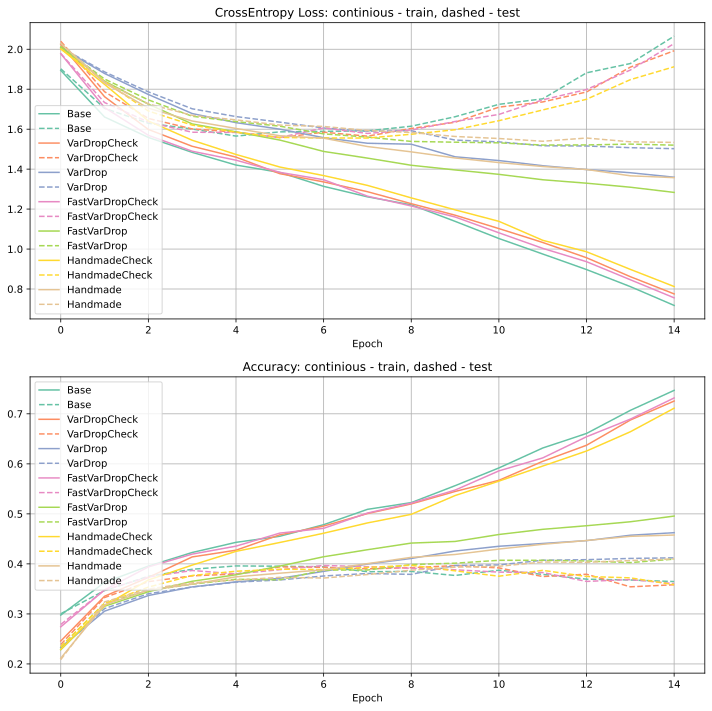

In [ ]:
fig, axes = plt.subplots(2, 1, figsize=(10, 10))
x = np.arange(num_epochs)
for i, model in enumerate(models_info):
    axes[0].plot(x, [y.cpu() for y in models_info[model]['train_losses']], 
                 color=palette[i], label=labels[i])
    axes[0].plot(x, [y.cpu() for y in models_info[model]['test_losses']], 
                 color=palette[i], label=labels[i], linestyle='--')
axes[0].legend()
axes[0].grid(True)
axes[0].set_xlabel('Epoch')
axes[0].set_title('CrossEntropy Loss: continious - train, dashed - test')

for i, model in enumerate(models_info):
    axes[1].plot(x, [y for y in models_info[model]['train_accuracies']], 
                 color=palette[i], label=labels[i])
    axes[1].plot(x, [y for y in models_info[model]['test_accuracies']], 
                 color=palette[i], label=labels[i], linestyle='--')
axes[1].legend()
axes[1].grid(True)
axes[1].set_xlabel('Epoch')
axes[1].set_title('Accuracy: continious - train, dashed - test')

fig.tight_layout()
plt.show()

Сделайте итоговые выводы о качестве работы моделей с разными реализациями DropOut:

**Ответ:**  
Из графиков видно, что на тесте качество лучше всего для тех моделей, которые используют дропаут, что связано с тем, что модели не переобучаются в этих случаях. Если в качестве меры качества брать пару -время и accuracy, то по accuracy все модели с дропаутом ведут себя примерно одинаково, однако по времени выигрывает FastVarDrop, поэтому именно он берет пальму первенства по мере качества, которую мы выбрали.

## `Бонус. Zoneout (0.5 балла)`

Это еще одна модификация идеи дропаута применительно к рекуррентным нейросетям. В Zoneout на каждом временном шаге с вероятностью $p$ компонента скрытого состояния обновляется, а с вероятностью $1-p$ берется с предыдущего шага. 
В Виде формул ($m^t_h$ - бинарная маска):
 
(сначала обычный рекуррентный переход, например LSTM)
$$
i = \sigma(h_{t-1}W^i + x_t U^i+b_i) \quad
o = \sigma(h_{t-1}W^o + x_t U^o+b_o) 
$$
$$
f = \sigma(h_{t-1}W^f + x_t U^f+b_f) \quad 
g = tanh(h_{t-1} W^g + x_t U^g+b_g) 
$$
$$
c_t = f \odot c_{t-1} +  i \odot  g \quad
h_t =  o \odot tanh(c_t)
$$
Затем Zoneout:
$$
h_t = h_t * m_h^t + h_{t-1}*(1-m_h^t)
$$
В этом методе маска уже должна быть разная во все моменты времени (иначе метод упрощается до дропаута Гала и Гарамани). На входы $x_t$ вновь можно накладывать маску до начала работы рекуррентного слоя.  

Если у вас осталось время, вы можете реализовать этот метод. Выберите основу из трех рассмотренных случаев самостоятельно.

**Полный балл ставится только при наличии качественного и количественного сравнения с предыдущими моделями.**

In [ ]:
class RNNZoneOutLayer(torch.nn.Module):
    def __init__(self, input_size, hidden_size, dropout=None):
        super().__init__()

        self.dropout = dropout
        self.input_size = input_size
        self.hidden_size = hidden_size
        
        self.rnn_cell = torch.nn.LSTMCell(self.input_size, self.hidden_size)
        
    def forward(self, x):
        # Initialize h_0, c_0
        # ht[ct].size() = (batch_size, hidden_size) [both]
        ht, ct = init_h0_c0(x.size(1), self.hidden_size, x)
        # Gen masks for input and hidden state


        # mx.size = [batch_size, input_size]
        mx, _ = gen_dropout_mask(
            x.size()[-2:], [0],
            self.training, self.dropout, x) 

        # Implement recurrent logic and return what nn.LSTM returns
        # x.size() = [sequence_length, batch_size, input_size]
        x = x * mx[None, :, :]
        
        output = []
        h_prev = ht
        # x[i].size() = [batch_size, input_size]
        for i in range(x.size(0)):

            # mh.size = [batch_size, hidden_size]
            _, mh = gen_dropout_mask(
                [0], (x.size(1), self.hidden_size),
                self.training, self.dropout, x) 
            
            # ht[ct].size() = (batch_size, hidden_size)
            ht, ct = self.rnn_cell(x[i], (ht, ct))
            ht = ht * mh + h_prev * (1 - mh)
            h_prev = ht
            output.append(ht)
        # output.size() = (sequence_length, batch_size, hidden_size)
        output = torch.stack(output, dim=0)
        return output, (ht, ct)

In [ ]:
model = RNNClassifier(
    embedding_dim=embedding_dim, hidden_dim=hidden_dim, output_size=10, vocab=v,
    rec_layer=HandmadeLSTM,
).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
start_time = time()
model_name = 'LSTM + Zoneout_0'
filepath = os.path.join('models_info', model_name) + '.pkl'
(models_info[model_name]['train_losses'],
 models_info[model_name]['train_accuracies'],
 models_info[model_name]['test_losses'],
 models_info[model_name]['test_accuracies']) = train(
    train_dataloader, test_dataloader, model, loss_fn, optimizer, device, num_epochs
)
end_time = time()
models_info[model_name]['time'] = end_time - start_time
with open(filepath, 'wb') as f:
    pickle.dump(models_info, f)

Epoch: 1/15. Loss (Train/Test): 1.972/1.980. Accuracy (Train/Test): 0.252/0.256
Epoch: 2/15. Loss (Train/Test): 1.755/1.780. Accuracy (Train/Test): 0.335/0.336
Epoch: 3/15. Loss (Train/Test): 1.618/1.670. Accuracy (Train/Test): 0.380/0.360
Epoch: 4/15. Loss (Train/Test): 1.549/1.632. Accuracy (Train/Test): 0.397/0.373
Epoch: 5/15. Loss (Train/Test): 1.464/1.581. Accuracy (Train/Test): 0.428/0.390
Epoch: 6/15. Loss (Train/Test): 1.393/1.564. Accuracy (Train/Test): 0.451/0.398
Epoch: 7/15. Loss (Train/Test): 1.354/1.566. Accuracy (Train/Test): 0.471/0.391
Epoch: 8/15. Loss (Train/Test): 1.283/1.574. Accuracy (Train/Test): 0.491/0.395
Epoch: 9/15. Loss (Train/Test): 1.230/1.600. Accuracy (Train/Test): 0.522/0.384
Epoch: 10/15. Loss (Train/Test): 1.163/1.653. Accuracy (Train/Test): 0.545/0.376
Epoch: 11/15. Loss (Train/Test): 1.088/1.667. Accuracy (Train/Test): 0.587/0.379
Epoch: 12/15. Loss (Train/Test): 1.007/1.778. Accuracy (Train/Test): 0.616/0.377
Epoch: 13/15. Loss (Train/Test): 0.93

Модель примерно также работает (по значениям лосса) как и другие модели без лосса

In [ ]:
model = RNNClassifier(
    embedding_dim=embedding_dim, hidden_dim=hidden_dim, output_size=10, vocab=v,
    rec_layer=HandmadeLSTM, dropout=0.25
).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
start_time = time()
model_name = 'LSTM + Zoneout_0.25'
filepath = os.path.join('models_info', model_name) + '.pkl'
(models_info[model_name]['train_losses'],
 models_info[model_name]['train_accuracies'],
 models_info[model_name]['test_losses'],
 models_info[model_name]['test_accuracies']) = train(
    train_dataloader, test_dataloader, model, loss_fn, optimizer, device, num_epochs
)
end_time = time()
models_info[model_name]['time'] = end_time - start_time
with open(filepath, 'wb') as f:
    pickle.dump(models_info, f)

Epoch: 1/15. Loss (Train/Test): 2.010/2.011. Accuracy (Train/Test): 0.250/0.251
Epoch: 2/15. Loss (Train/Test): 1.935/1.943. Accuracy (Train/Test): 0.272/0.279
Epoch: 3/15. Loss (Train/Test): 1.752/1.779. Accuracy (Train/Test): 0.335/0.337
Epoch: 4/15. Loss (Train/Test): 1.669/1.705. Accuracy (Train/Test): 0.351/0.350
Epoch: 5/15. Loss (Train/Test): 1.620/1.666. Accuracy (Train/Test): 0.363/0.358
Epoch: 6/15. Loss (Train/Test): 1.586/1.646. Accuracy (Train/Test): 0.380/0.363
Epoch: 7/15. Loss (Train/Test): 1.537/1.608. Accuracy (Train/Test): 0.396/0.381
Epoch: 8/15. Loss (Train/Test): 1.513/1.588. Accuracy (Train/Test): 0.405/0.387
Epoch: 9/15. Loss (Train/Test): 1.480/1.575. Accuracy (Train/Test): 0.416/0.392
Epoch: 10/15. Loss (Train/Test): 1.455/1.567. Accuracy (Train/Test): 0.427/0.399
Epoch: 11/15. Loss (Train/Test): 1.428/1.544. Accuracy (Train/Test): 0.433/0.403
Epoch: 12/15. Loss (Train/Test): 1.415/1.546. Accuracy (Train/Test): 0.440/0.398
Epoch: 13/15. Loss (Train/Test): 1.38

In [ ]:
print('torch.nn.LSTM', str(datetime.timedelta(seconds=models_info['Pure LSTM']['time'])))
print('VarDrop 0.25', str(datetime.timedelta(seconds=models_info['LSTM + Variational Dropout_0.25']['time'])))
print('Semeniuta 0.25', str(datetime.timedelta(seconds=models_info['LSTM + Semeniuta_0.25']['time'])))
print('Zoneout 0.25', str(datetime.timedelta(seconds=models_info['LSTM + Zoneout_0.25']['time'])))

torch.nn.LSTM 0:01:33.034177
VarDrop 0.25 0:11:24.494173
Semeniuta 0.25 0:25:12.303572
Zoneout 0.25 0:25:25.479110


In [ ]:
labels = ['Base', 'VarDropCheck', 'VarDrop', 'FastVarDropCheck', 
          'FastVarDrop', 'HandmadeCheck', 'Handmade', 'ZoneoutCheck', 'Zoneout']
palette = sns.color_palette("Paired")
len(palette)

12

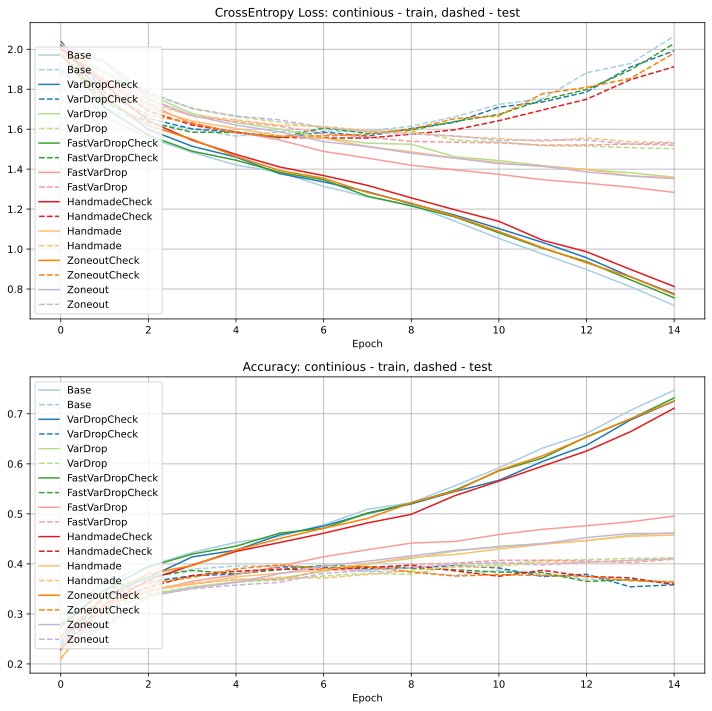

In [ ]:
fig, axes = plt.subplots(2, 1, figsize=(10, 10))
x = np.arange(num_epochs)
for i, model in enumerate(models_info):
    axes[0].plot(x, [y.cpu() for y in models_info[model]['train_losses']], 
                 color=palette[i], label=labels[i])
    axes[0].plot(x, [y.cpu() for y in models_info[model]['test_losses']], 
                 color=palette[i], label=labels[i], linestyle='--')
axes[0].legend()
axes[0].grid(True)
axes[0].set_xlabel('Epoch')
axes[0].set_title('CrossEntropy Loss: continious - train, dashed - test')

for i, model in enumerate(models_info):
    axes[1].plot(x, [y for y in models_info[model]['train_accuracies']], 
                 color=palette[i], label=labels[i])
    axes[1].plot(x, [y for y in models_info[model]['test_accuracies']], 
                 color=palette[i], label=labels[i], linestyle='--')
axes[1].legend()
axes[1].grid(True)
axes[1].set_xlabel('Epoch')
axes[1].set_title('Accuracy: continious - train, dashed - test')

fig.tight_layout()
plt.show()

Видно, что переобучения нет с ZoneOut, качество на тесте примерно такое же как и для всех моделей с дропаутом, однако время незначительно, но увеличилось в сравнении с моделью Semeniuta (которая, напомню, работала дольше всех) - это связано с тем что модель для каждого момента времени генерирует новые случайные маски (под капотом)

# `Часть 2. Language Modeling с помощью LSTM (5 баллов)`

Во второй части мы попробуем обучить модель для генерации отзывов по их началу.

Концептуально модель будет выглядеть следующим образом:
    
![image info](https://blog.feedly.com/wp-content/uploads/2019/03/Screen-Shot-2019-03-06-at-12.08.35-PM.png)

В процессе обучения будем тренировать сеть предсказывать вероятность следующего символа при условии всех предыдущих. Эту вероятность можно моделировать с помощью скрытого состояния $h^{(t)}$ пропуская его через линейный слой с выходной размерностью равной размерности словаря:
$$
p(x^{t}|x^{t-1}, ..., x^{1}) = SoftMax(Linear(h^{(t)}))
$$

Обратите внимание, что для вычисления $p(x^{t}|x^{t-1}, ..., x^{1})$ для всех моментов времени достаточно сделать один проход по RNN, а затем применить линейное преобразование ко всем скрытым состояниям.

В качестве функции потерь необходимо использовать `CrossEntropy`.

Рассмотрим другой важный момент. Для того, чтобы решить данную задачу, модель должна уметь определять момент начала генерации предложения и оповещать о завершении генерации — конце предложения. Для этого добавим в словарь вспомогательные токены `<sos>`, `<eos>`. Добавив `<sos>` в начало каждого предложения и `<eos>` в конец.

Модель сможет начинать генерацию как только ей будет передан токен `<sos>` и заканчивать генерацию, как только на очередном месте самым вероятным токеном оказывается `<eos>`.

Для решения этой задачи мы воспользуемся уже реализованной LSTM с дропаутом `FastRNNLayer` и классом `RNNClassifier`, то есть архитектура сети принципиально не поменяется. 

## `Реализация модели и цикла обучения (2 балла)`

**Не используйте циклы в `RNNLM`, `LMCrossEntropyLoss`, `LMAccuracy`**

In [84]:
class RNNLM(RNNClassifier):
    def __init__(
        self, embedding_dim, hidden_dim, vocab, dropout=0.5, layers_dropout=0.5, num_layers=1
    ):
        super().__init__(
            embedding_dim=embedding_dim, hidden_dim=hidden_dim, output_size=len(vocab), vocab=vocab,
            rec_layer=FastRNNLayer, dropout=dropout, layers_dropout=layers_dropout, num_layers=num_layers
        )
    
    def forward(self, tokens, tokens_lens):
        """
        :param torch.Tensor(dtype=torch.long) tokens: 
            Batch of texts represented with tokens. Shape: [T, B]
        :param torch.Tensor(dtype=torch.long) tokens_lens: 
            Number of non-padding tokens for each object in batch. Shape: [B]
        :return torch.Tensor: 
            Distribution of next token for each time step. Shape: [T, B, V], V — size of vocabulary
        """
        # Make embeddings for all tokens
        output = self.word_embeddings(tokens)
        
        # Forward pass embeddings through network
        output = self.rnn(output)[0]
        
        # Take all hidden states from the last layer of LSTM for each step and perform linear transformation
        output = self.final(output)
        return output

Реализуем функцию потерь для данной задачи. 

Моменты на которые нужно обратить внимание:
1. Распределение вероятности следующего токена для последнего токена в последовательности не участвует в подсчёте функции потерь.
2. Необходимо учитывать, что в одном батче могут быть тексты разной длины.

Для решения второй проблемы можно воспользоваться функцией `torch.nn.utils.rnn.pack_padded_sequence`. 

Принимая на вход батч тензоров и длину каждого тензора без учёта паддинга эта функция позволяет получить все элементы в тензорах, которые не относятся к паддингу в виде плоского массива:

In [85]:
padded_tensors = torch.tensor([
    [[1, 11, 111], [2, 22, 222], [3, 33, 333]],
    [[4, 44, 444], [5, 55, 555], [6, 66, 666]],
    [[7, 77, 777], [0, 0, 0], [8, 88, 888]],
    [[9, 99, 999], [0, 0, 0], [0, 0, 0]]
])
tensors_lens = torch.tensor([4, 2, 3])

Обратите внимание, что `torch.nn.utils.rnn.pack_padded_sequence` автоматически переупорядочивает тензоры в батче по убыванию их длины.

In [86]:
torch.nn.utils.rnn.pack_padded_sequence(padded_tensors, tensors_lens, batch_first=False, enforce_sorted=False)

PackedSequence(data=tensor([[  1,  11, 111],
        [  3,  33, 333],
        [  2,  22, 222],
        [  4,  44, 444],
        [  6,  66, 666],
        [  5,  55, 555],
        [  7,  77, 777],
        [  8,  88, 888],
        [  9,  99, 999]]), batch_sizes=tensor([3, 3, 2, 1]), sorted_indices=tensor([0, 2, 1]), unsorted_indices=tensor([0, 2, 1]))

In [87]:
from torch.nn.utils.rnn import pack_padded_sequence

In [88]:
class LMCrossEntropyLoss(torch.nn.CrossEntropyLoss):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        
    def forward(self, outputs, tokens, tokens_lens):
        """
        :param torch.Tensor outputs: Output from RNNLM.forward. Shape: [T, B, V]
        :param torch.Tensor tokens: Batch of tokens. Shape: [T, B]
        :param torch.Tensor tokens_lens: Length of each sequence in batch
        :return torch.Tensor: CrossEntropyLoss between corresponding logits and tokens
        """
        # Use torch.nn.utils.rnn.pack_padded_sequence().data to remove padding and flatten logits and tokens
        # Do not forget specify enforce_sorted=False and correct value of batch_first 
        packed_outputs = pack_padded_sequence(
            outputs, tokens_lens.cpu() + 1, batch_first=False, enforce_sorted=False).data

        # [<sos>, first_elem, second_elem, ..., last_elem, <eos>]
        packed_tokens = pack_padded_sequence(
            tokens[1:], tokens_lens.cpu() + 1, batch_first=False, enforce_sorted=False).data
        
        # Use super().forward(..., ...) to compute CrossEntropyLoss
        loss = super().forward(packed_outputs, packed_tokens)
        return loss

Для оценки качества нам также необходимо вычислять долю правильно предсказанных токенов. Реализуйте класс для вычисления точности.

In [89]:
class LMAccuracy(torch.nn.Module):
    def __init__(self):
        super().__init__()
        
    def forward(self, outputs, tokens, tokens_lens):
        """
        :param torch.Tensor outputs: Output from RNNLM.forward. Shape: [T, B, V]
        :param torch.Tensor tokens: Batch of tokens. Shape: [T, B]
        :param torch.Tensor tokens_lens: Length of each sequence in batch
        :return torch.Tensor: Accuracy for given logits and tokens
        """
        # Use torch.nn.utils.rnn.pack_padded_sequence().data to remove padding and flatten logits and tokens
        # Do not forget specify enforce_sorted=False and correct value of batch_first 
        # YOUR CODE HERE
        packed_outputs = pack_padded_sequence(
            outputs, tokens_lens.cpu() + 1, batch_first=False, enforce_sorted=False).data
        packed_tokens = pack_padded_sequence(
            tokens[1:], tokens_lens.cpu() + 1, batch_first=False, enforce_sorted=False).data
        #print(torch.argmax(packed_outputs, dim=1) == packed_tokens)
        return (torch.argmax(packed_outputs, dim=1) == packed_tokens).mean(dtype=torch.float32)
        

Модифицируйте функции `train_epoch`, `evaluate`, `train` для обучения LM.

**При вычислении точности, обратите внимание на то, что мы не предсказываем первый токен в каждой последовательности и токены, относящиеся к паддингу.**

In [90]:
def train_epoch_lm(dataloader, model, loss_fn, optimizer, device):
    model.train()
    for idx, data in enumerate(dataloader):

        # 1. Take data from batch
        tokens = data['tokens'].to(device)
        tokens_lens = data['tokens_lens'].to(device)

        # 2. Perform forward pass
        model.zero_grad()
        output = model(tokens, tokens_lens)

        # 3. Evaluate loss
        loss = loss_fn(output, tokens, tokens_lens)
        loss.backward()
        # 4. Make optimizer step
        optimizer.step()

    
def evaluate_lm(dataloader, model, loss_fn, device):
    model.eval()
    
    total_tokens = 0
    total_loss = 0.0
    total_accuracy = 0.0
    
    accuracy_fn = LMAccuracy()
    with torch.no_grad():
        for idx, data in enumerate(dataloader):

            # 1. Take data from batch
            tokens = data['tokens'].to(device)
            tokens_lens = data['tokens_lens'].to(device)

            # 2. Perform forward pass
            output = model(tokens, tokens_lens)

            # 3. Evaluate loss
            num_tokens = tokens_lens.sum()
            total_loss += loss_fn(output, tokens, tokens_lens) * num_tokens
            # 4. Evaluate accuracy
            total_accuracy += accuracy_fn(output, tokens, tokens_lens) * num_tokens
            
            total_tokens += num_tokens
            
    return total_loss / total_tokens, total_accuracy / total_tokens

def train_lm(
    train_loader, test_loader, model, loss_fn, optimizer, device, num_epochs
):
    test_losses = []
    train_losses = []
    test_accuracies = []
    train_accuracies = []
    for epoch in range(num_epochs):
        train_epoch_lm(train_loader, model, loss_fn, optimizer, device)
        
        train_loss, train_acc = evaluate_lm(train_loader, model, loss_fn, device)
        train_accuracies.append(train_acc)
        train_losses.append(train_loss)
        
        test_loss, test_acc = evaluate_lm(test_loader, model, loss_fn, device)
        test_accuracies.append(test_acc)
        test_losses.append(test_loss)
        
        print(
            'Epoch: {0:d}/{1:d}. Loss (Train/Test): {2:.3f}/{3:.3f}. Accuracy (Train/Test): {4:.3f}/{5:.3f}'.format(
                epoch + 1, num_epochs, train_losses[-1], test_losses[-1], train_accuracies[-1], test_accuracies[-1]
            )
        )
    return train_losses, train_accuracies, test_losses, test_accuracies

Теперь у нас всё готово для обучения модели.

Создадим словарь с `<sos>`, `<eos>` токенами.

Обратите внимание, что в отличие от классификации текстов нам необходимо значительно увеличить размер словаря, чтобы доля `<unk>` токенов была не велика.

Так же, так как задача генерации значительно сложнее задачи классификации текстов будем обучать модель только на префиксах рецензий длины $20$. Это позволяет значительно ускорить обучение.

In [91]:
specials = ['<pad>', '<unk>', '<sos>', '<eos>']
for special in specials:
    counter[special] = 0
# min_freq=8 is approximately equivalent to max_size=30000. 
#   You can lower min_freq in order to make model vocabulary more diverse 
lm_vocab = torchtext.vocab.vocab(counter, specials=specials, special_first=True, min_freq=4)

In [92]:
len(lm_vocab)
lm_vocab.set_default_index(lm_vocab['<unk>'])

In [93]:
lm_test_dataset = LargeMovieReviewDataset(test_data_path, lm_vocab, max_len=20, pad_sos=True, pad_eos=True)
lm_train_dataset = LargeMovieReviewDataset(train_data_path, lm_vocab, max_len=20, pad_sos=True, pad_eos=True)

Создадим даталоадеры для тестовой и обучающей выборок:

In [94]:
lm_test_dataloader = DataLoader(
    lm_test_dataset, batch_size=96, shuffle=False, num_workers=2, 
    collate_fn=partial(collate_fn, padding_value=lm_vocab.lookup_indices(['<pad>'])[0])
)
lm_train_dataloader = DataLoader(
    lm_train_dataset, batch_size=96, shuffle=True, num_workers=2, 
    collate_fn=partial(collate_fn, padding_value=lm_vocab.lookup_indices(['<pad>'])[0])
)

Убедитесь, что все предложения имеют в начале `<sos>` токен, а в конце — `<eos>` токен.

In [95]:
batch = next(iter(lm_train_dataloader))
batch['tokens'], batch['tokens_lens']

(tensor([[    2,     2,     2,  ...,     2,     2,     2],
         [ 2399,   526,  5175,  ...,   994,  4803,  5476],
         [  270,   540,  1208,  ...,   180,  1995, 19560],
         ...,
         [ 2575,  1406,   741,  ...,  6041,  2967,  7948],
         [ 1851,   407,  6690,  ...,   100,  7532,   160],
         [    3,     3,     3,  ...,     3,     3,     3]]),
 tensor([20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20,
         20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20,
         20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20,
         20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20,
         20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20,
         20, 20, 20, 20, 20, 20]))

Создадим модель, функцию потерь и оптимизатор: 

In [96]:
lm_model = RNNLM(
    embedding_dim=512, hidden_dim=512, vocab=lm_vocab, dropout=0.6, layers_dropout=0.6, num_layers=2
).to(device=device)

In [97]:
lm_loss_fn = LMCrossEntropyLoss(reduction='mean')
lm_optimizer = torch.optim.Adam(lm_model.parameters(), lr=0.005, weight_decay=1.2e-6)

Обучим модель:

In [98]:
lm_train_losses, lm_train_accuracies, lm_test_losses, lm_test_accuracies = train_lm(
    lm_train_dataloader, lm_test_dataloader, lm_model, lm_loss_fn, lm_optimizer, device, 10
)

Epoch: 1/10. Loss (Train/Test): 7.684/7.821. Accuracy (Train/Test): 0.079/0.079
Epoch: 2/10. Loss (Train/Test): 7.439/7.668. Accuracy (Train/Test): 0.083/0.082
Epoch: 3/10. Loss (Train/Test): 7.195/7.536. Accuracy (Train/Test): 0.093/0.092
Epoch: 4/10. Loss (Train/Test): 6.996/7.476. Accuracy (Train/Test): 0.096/0.094
Epoch: 5/10. Loss (Train/Test): 6.789/7.438. Accuracy (Train/Test): 0.099/0.095
Epoch: 6/10. Loss (Train/Test): 6.587/7.426. Accuracy (Train/Test): 0.104/0.098
Epoch: 7/10. Loss (Train/Test): 6.396/7.435. Accuracy (Train/Test): 0.108/0.100
Epoch: 8/10. Loss (Train/Test): 6.217/7.465. Accuracy (Train/Test): 0.114/0.102
Epoch: 9/10. Loss (Train/Test): 6.038/7.489. Accuracy (Train/Test): 0.117/0.102
Epoch: 10/10. Loss (Train/Test): 5.895/7.533. Accuracy (Train/Test): 0.123/0.102


## `Реализация декодера (1 балл)`

Теперь, реализуем последнюю деталь — декодирование с использованием обученной модели.
Есть несколько вариантов. Рассмотрим два самых простых:
1. **Жадное декодирование.** На каждом шаге мы выбираем токен с максимальной вероятностью и используем его для обновления скрытого состояния RNN.
2. **Top-k sampling.** На очередном шаге рассматриваются $k$ токенов с самыми большими вероятностями. Остальные токены игнорируются. Из выбранных токенов семплируется следующий токен пропорционально их вероятностям.

Прочитать подробнее про разные варианты декодирования можно по ссылкам:
1. [От huggingface](https://huggingface.co/blog/how-to-generate)
2. [На towardsdatascience](https://towardsdatascience.com/decoding-strategies-that-you-need-to-know-for-response-generation-ba95ee0faadc)

Существенным в процессе декодирования является критерий останова. Как только очередной самый вероятный символ оказался `<eos>`, то данная последовательность считается сгенерированной. Однако, может так оказаться, что `<eos>` никогда не будет выбран, тогда необходимо прекратить генерацию, как только длина последовательности перейдёт порог `max_generated_len`.

In [100]:
@torch.no_grad()
def decode(model, start_tokens, start_tokens_lens, max_generated_len=20, top_k=None):
    """
    :param RNNLM model: Model
    :param torch.Tensor start_tokens: Batch of seed tokens. Shape: [T, B]
    :param torch.Tensor start_tokens_lens: Length of each sequence in batch. Shape: [B]
    :param int max_generated_len: Maximum lenght of generated samples
    :param Optional[int] top_k: Number of tokens with the largest probability to sample from
    :return Tuple[torch.Tensor, torch.Tensor]. 
        Newly predicted tokens and length of generated part. Shape [T*, B], [B]
    """
    # Get embedding for start_tokens
    embedding = model.word_embeddings(start_tokens)
    
    # Pass embedding through rnn and collect hidden states and cell states for each time moment
    all_h, all_c = [], []
    h = embedding.new_zeros([model.rnn.num_layers, start_tokens.shape[1], model.hidden_dim])
    c = embedding.new_zeros([model.rnn.num_layers, start_tokens.shape[1], model.hidden_dim])
    for time_step in range(start_tokens.shape[0]):
        # h.size() = (1, B, emb_dim) 
        h, c = model.rnn(embedding[time_step].unsqueeze(0), (h, c))[1]
        all_h.append(h)
        all_c.append(c)

    all_h = torch.stack(all_h, dim=1)
    all_c = torch.stack(all_c, dim=1)
    # Take final hidden state and cell state for each start sequence in batch
    # We will use them as h_0, c_0 for generation new tokens
    h = all_h[:, start_tokens_lens - 1, torch.arange(start_tokens_lens.shape[0])]
    c = all_c[:, start_tokens_lens - 1, torch.arange(start_tokens_lens.shape[0])]

    # List of predicted tokens for each time step
    predicted_tokens = []
    # Length of generated part for each object in the batch
    decoded_lens = torch.zeros_like(start_tokens_lens, dtype=torch.long)
    # Boolean mask where we store if the sequence has already generated
    # i.e. `<eos>` was selected on any step
    is_finished_decoding = torch.zeros_like(start_tokens_lens, dtype=torch.bool)
    
    # Stop when all sequences in the batch are finished
    while not torch.all(is_finished_decoding) and torch.max(decoded_lens) < max_generated_len:
        # Evaluate next token distribution using hidden state h.
        # Note. Over first dimension h has hidden states for each layer of LSTM.
        #     We must use hidden state from the last layer
        
        # h.size = [number of layers, batch size, hidden dim]
        #logits.size = [batch size, len(vocab)]
        logits = model.final(h[-1])
        
        if top_k is not None:
            # Top-k sampling. Use only top-k most probable logits to sample next token
            indices_to_remove = logits < torch.topk(logits, top_k)[0][..., -1, None]
            # Mask non top-k logits
            logits[indices_to_remove] = -1e10
            # Sample next_token. 
            distr = (torch.distributions
                          .categorical.Categorical(logits=logits))
            next_token = distr.sample()
        else:
            # Select most probable token
            next_token = logits.argmax(dim=1)
            
        predicted_tokens.append(next_token)
        
        decoded_lens += (~is_finished_decoding)
        is_finished_decoding |= (next_token == torch.tensor(model.vocab.lookup_indices(['<eos>'])[0]))

        # Compute embedding for next token
        embedding = model.word_embeddings(next_token)
        
        # Update hidden and cell states
        h, c = model.rnn(embedding.unsqueeze(0), (h, c))[1]
        
    return torch.stack(predicted_tokens), decoded_lens

Попробуем сгенерировать продолжения для нескольких префиксов:

In [101]:
start_tokens = torch.tensor([
    lm_model.vocab.lookup_indices(['<sos>', '<pad>', '<pad>', '<pad>']),
    lm_model.vocab.lookup_indices(['<sos>', 'my', 'favorite', 'movie']),
    lm_model.vocab.lookup_indices(['<sos>', 'the', 'best', 'movie']),
    lm_model.vocab.lookup_indices(['<sos>', 'the', 'worst', 'movie']),
]).T

start_tokens_lens = torch.tensor([1, 4, 4, 4])

In [102]:
lm_model = lm_model.cpu()
lm_model.eval()
decoded_tokens, decoded_lens = decode(lm_model, start_tokens, start_tokens_lens, max_generated_len=20, top_k=5)

In [103]:
for text_idx in range(start_tokens.shape[1]):
    decoded_text_tokens = decoded_tokens[:decoded_lens[text_idx], text_idx]
    tokens = start_tokens[:start_tokens_lens[text_idx], text_idx].tolist() + decoded_text_tokens.tolist()
    words = np.array(lm_model.vocab.get_itos())[np.array(tokens)]
    print(' '.join(words))

<sos> movie really funny plot predictable acting terrible acting bad directing bad plot ridiculous story bad acting poor special effects bad
<sos> <unk> favorite movie one great <unk> story line good acting good story line good acting good movie bad good acting good special effects
<sos> <unk> best movie <unk> seen years old friends still <unk> movie <unk> <unk> <unk> <unk> movie <unk> story line <unk> <unk> <eos>
<sos> <unk> worst movie ever seen terrible movie ever seen worse movie bad plot bad plot holes could make movie bad actually bad movies


Попробуйте выполнить семплирование для разных $k$. Сравните результаты top-k семплирования с жадным декодированием. Опишите ваши наблюдения.

In [104]:
def gen_text(top_k):
    decoded_tokens, decoded_lens = decode(lm_model, start_tokens, start_tokens_lens, max_generated_len=20, top_k=top_k)
    for text_idx in range(start_tokens.shape[1]):
        decoded_text_tokens = decoded_tokens[:decoded_lens[text_idx], text_idx]
        tokens = start_tokens[:start_tokens_lens[text_idx], text_idx].tolist() + decoded_text_tokens.tolist()
        words = np.array(lm_model.vocab.get_itos())[np.array(tokens)]
        print(' '.join(words))

In [105]:
print("Vanila greedy algorithm")
gen_text(None)

Vanila greedy algorithm
<sos> movie one best movies ever seen movie <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk>
<sos> <unk> favorite movie ever seen movie <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk>
<sos> <unk> best movie ever seen movie <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk>
<sos> <unk> worst movie ever seen movie bad acting bad script bad acting bad script bad special effects bad movie bad acting bad <eos>


In [106]:
for k in range(1, 21, 3):
    print('-' * 30)
    print(f'top_k = {k}')
    print('-' * 30)
    gen_text(k)

------------------------------
top_k = 1
------------------------------
<sos> movie one best movies ever seen movie <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk>
<sos> <unk> favorite movie ever seen movie <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk>
<sos> <unk> best movie ever seen movie <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk>
<sos> <unk> worst movie ever seen movie bad acting bad script bad acting bad script bad special effects bad movie bad acting bad <eos>
------------------------------
top_k = 4
------------------------------
<sos> one worst movies seen long time watching entire life movie could possibly best movie ever seen movie bad acting terrible
<sos> <unk> favorite movie ever since saw movie theater ago still disappointed movie first saw film <unk> movie started seeing movie theater <eos>
<sos> <unk> best movie ever seen <unk> 

**Ответ:**

1. Видно, что при top_k = 1 top-k algorithm эквивалентен greedy search (у них тексты  совпадают + это очевидно из реализации). 
2. При увеличении k в top-k algorithm текст становится более богатым в смысле разнообразия входящих в него слов + смысл текста становится более понятным + уменьшается количество \<unk\>

## `Beam Search (2 балла)`

Рассмотрим более продвинутый алгоритм для декодирования. Реализуйте алгоритм Beam Search.

Несколько замечаний по имплементации:

1. При больших размерах `beam_size` число гипотез ($B \times \text{beam\_size}$) на очередном шаге может быть слишком большим. Поэтому может потребоваться разбить все гипотезы на отдельные батчи и делать forward-pass в несколько итераций. Используйте [`torch.split`](https://pytorch.org/docs/stable/generated/torch.split.html)
2. Для выбора лучших гипотез используйте [`torch.topk`](https://pytorch.org/docs/stable/generated/torch.topk.html). Обратите внимание на индексы, которые возвращает эта функция (может пригодиться метод [`torch.remainder`](https://pytorch.org/docs/stable/generated/torch.remainder.html))
3. Можно отслеживать, какие элементы в батче (или какие гипотезы) закончили генерацию. Делая forward-pass только для незавершённых гипотез, можно ускорить декодинг, однако, это усложнит реализацию

In [107]:
@torch.no_grad()
def decode_beam_search(model, start_tokens, start_tokens_lens, max_generated_len=20, beam_size=5):
    """
    :param RNNLM model: Model
    :param torch.Tensor start_tokens: Batch of seed tokens. Shape: [T, B]
    :param torch.Tensor start_tokens_lens: Length of each sequence in batch. Shape: [B]
    :param int max_generated_len: Maximum length of generated samples
    :param int beam_size: Size of beam
    :return Tuple[torch.Tensor, torch.Tensor, torch.Tensor]. 
        Newly predicted tokens, probabilities for each hypotheses and lengths of generated parts
        Shape [T*, B, beam_size], [T*, B, beam_size], [B, beam_size]
    """
    vocab_size = len(model.vocab)
    batch_size = start_tokens.shape[1]
    softmax = torch.nn.Softmax(dim=1)
    # Get embedding for start_tokens
    embedding = model.word_embeddings(start_tokens)
    
    # Pass embedding through rnn and collect hidden states and cell states for each time moment
    all_h, all_c = [], []
    h = embedding.new_zeros([model.rnn.num_layers, start_tokens.shape[1], model.hidden_dim])
    c = embedding.new_zeros([model.rnn.num_layers, start_tokens.shape[1], model.hidden_dim])
    for time_step in range(start_tokens.shape[0]):
        # h.size() = [L, B, Hdim] 
        h, c = model.rnn(embedding[time_step].unsqueeze(0), (h, c))[1]
        all_h.append(h)
        all_c.append(c)

    # all_h.size() = [L, T, B, Hdim]
    all_h = torch.stack(all_h, dim=1)
    all_c = torch.stack(all_c, dim=1)
    # Take final hidden state and cell state for each start sequence in batch
    # We will use them as h_0, c_0 for generation new tokens
    h = all_h[:, start_tokens_lens - 1, torch.arange(start_tokens_lens.shape[0])]
    c = all_c[:, start_tokens_lens - 1, torch.arange(start_tokens_lens.shape[0])]


    # Length of generated part for each object in the batch
    decoded_lens = torch.zeros(
        (start_tokens_lens.size(0), beam_size), dtype=torch.long)
    # Boolean mask where we store if the sequence has already generated
    # i.e. `<eos>` was selected on any step
    # size = [B, beam_size]
    is_finished_decoding = torch.zeros(
        (start_tokens_lens.size(0), beam_size), dtype=torch.bool)
    # 1. Initialize beams and hypotheses probabilities for each element in the batch

    # logits.size = [B, len(vocab)]
    logits = model.final(h[-1])
    top_k_logits, top_k_tokens = torch.topk(logits, beam_size)

    # beams.size = (T, B, beam_size)
    beams = top_k_tokens.unsqueeze(0)

    # seq_probs = [T, B, beam_size]
    seq_probs = softmax(top_k_logits).unsqueeze(0)
    decoded_lens += ~is_finished_decoding
    is_finished_decoding |= (beams[-1] == 
                             torch.tensor(model.vocab['<eos>']))
    # 2. While all sequences do not end with <eos> and their length less than max_generated_len
    #    1. Perform forward pass and obtain probabilities for all extensions
    #    2. Compute probabilities for all hypotheses
    #    3. Select top-beam_size hypotheses for each element in the batch
    #    4. Take tokens that correspond to the chosen hypotheses
    #    5. Concat new tokens to existing prefixes
    h_beams = []
    c_beams = []
    for beam_idx in range(beam_size):
        # embedding size = [T, B, Edim]
        embedding = model.word_embeddings(beams[-1, :, beam_idx])
        # h, c = [L, B, Hdim]
        h, c = model.rnn(embedding.unsqueeze(0), (h, c))[1]
        # [beam_size, number of layers, B, H]
        h_beams.append(h)
        c_beams.append(c)
    while not torch.all(is_finished_decoding) and torch.max(decoded_lens) < max_generated_len:
        # Evaluate next token distribution using hidden state h.
        # Note. Over first dimension h has hidden states for each layer of LSTM.
        #     We must use hidden state from the last layer
        
        # h.size = [number of layers, batch size, hidden dim]
        #logits.size = [batch size, len(vocab)]
        new_seq_probs = []
        for beam_idx in range(beam_size):
            
            # logits.size = [batch size, len(vocab)]
            logits = model.final(h_beams[beam_idx][-1])
            # new_seq_probs.size = [beam_size, batch size, len(vocab)]
            # seq_probs.size = [T, B, beam_size]
            new_seq_probs.append(softmax(logits) * 
                                 seq_probs[-1, :, beam_idx][:, None])
            is_finished_beam = is_finished_decoding[:, beam_idx]
            if torch.any(is_finished_beam):
                eos_lens = decoded_lens[is_finished_beam, beam_idx]
                # eos_probs.size = (amount of ended beams, T) 
                # (after next code line)
                eos_probs = seq_probs[:, is_finished_beam, beam_idx].permute([1, 0])
                new_seq_probs[beam_idx][is_finished_beam] = -1
                new_seq_probs[beam_idx][is_finished_beam, model.vocab['<eos>']] = eos_probs[torch.arange(len(eos_lens)), eos_lens - 1]
                

        # (B, beam_size, len(vocab)) (after next code str)
        new_seq_probs = torch.stack(new_seq_probs).permute([1, 0, 2])
        
        # probs.size = [B, beam_size]
        probs, idxs = torch.topk(new_seq_probs.flatten(start_dim=1), beam_size)
        # beam_idxs.size = [B, beam_size]
        beam_idxs = idxs // vocab_size
        tokens = torch.remainder(idxs, vocab_size)
        probs = probs.unsqueeze(0)
        tokens = tokens.unsqueeze(0)
        # seq_probs = [T, B, beam_size]
        batch_idxs = torch.arange(batch_size)[:, None]
        seq_probs = torch.cat((seq_probs[:, batch_idxs, beam_idxs], probs), dim=0)
        beams = torch.cat((beams[:, batch_idxs, beam_idxs], tokens), dim=0)
        decoded_lens = decoded_lens[batch_idxs, beam_idxs]
        is_finished_decoding = is_finished_decoding[batch_idxs, beam_idxs]
        decoded_lens += (~is_finished_decoding)
        is_finished_decoding |= (beams[-1] == 
                                 torch.tensor(model.vocab['<eos>']))
        

        for beam_idx in range(beam_size):
            # embedding size = [T, B, Edim]
            embedding = model.word_embeddings(beams[-1, :, beam_idx])
            # h, c = [L, B, Hdim]
            h_beams[beam_idx], c_beams[beam_idx] = model.rnn(
                embedding.unsqueeze(0), (h_beams[beam_idx], c_beams[beam_idx]))[1]
            # [beam_size, number of layers, B, H]

    return beams, seq_probs, decoded_lens
            

Попробуйте выполнить декодинг для разных `beam_size`. Убедитесь, что при `beam_search=1` семплирование совпадает с top-1 (greedy decoding) подходом. 

Сравните результаты Beam Search с top-k семплированием и жадным декодированием. Опишите ваши наблюдения.

In [108]:
lm_model = lm_model.cpu()
lm_model.eval()
beam_size = 10
decoded_tokens, decoded_probs, decoded_lens = decode_beam_search(lm_model, start_tokens, start_tokens_lens, max_generated_len=20, beam_size=beam_size)

In [109]:
for text_idx in range(start_tokens.shape[1]):
    print('-' * 30)
    print(f'text with idx = {text_idx}')
    print('-' * 30)
    for beam_idx in range(beam_size):
        decoded_text_tokens = decoded_tokens[:decoded_lens[text_idx, beam_idx], text_idx, beam_idx]
        #decoded_text_tokens = decoded_tokens[:, text_idx, beam_idx]
        tokens = start_tokens[:start_tokens_lens[text_idx], text_idx].tolist() + decoded_text_tokens.tolist()
        words = np.array(lm_model.vocab.get_itos())[np.array(tokens)]
        print(' '.join(words), 
              'sequence probability', decoded_probs[-1, text_idx, beam_idx].item())

------------------------------
text with idx = 0
------------------------------
<sos> one best movies ever seen long time saw movie ever made <eos> sequence probability 2.1966099078563062e-11
<sos> one best movies ive ever seen movie ive seen movie ever saw <eos> sequence probability 3.2086898242578155e-12
<sos> one best movies ever seen long time movie ever since first time <unk> <eos> sequence probability 4.2335582197024213e-13
<sos> one best movies ever seen long time movie ever seen years ago thought would <eos> sequence probability 7.865720742924673e-14
<sos> one best movies ever seen long time movie ever seen years ago watched movie <eos> sequence probability 2.8712472124273886e-14
<sos> one best movies ever seen long time movie ever seen years ago one night <eos> sequence probability 2.708231825376741e-14
<sos> one best movies ever seen long time movie ever seen years ago ive never saw <eos> sequence probability 6.736752032143831e-15
<sos> one best movies ever seen long time mov

In [110]:
beam_size = 1
decoded_tokens, decoded_probs, decoded_lens = decode_beam_search(lm_model, start_tokens, start_tokens_lens, max_generated_len=20, beam_size=beam_size)
for text_idx in range(start_tokens.shape[1]):
    print('-' * 30)
    print(f'text with idx = {text_idx}')
    print('-' * 30)
    for beam_idx in range(beam_size):
        decoded_text_tokens = decoded_tokens[:decoded_lens[text_idx, beam_idx], text_idx, beam_idx]
        #decoded_text_tokens = decoded_tokens[:, text_idx, beam_idx]
        tokens = start_tokens[:start_tokens_lens[text_idx], text_idx].tolist() + decoded_text_tokens.tolist()
        words = np.array(lm_model.vocab.get_itos())[np.array(tokens)]
        print(' '.join(words), 
              'sequence probability', decoded_probs[-1, text_idx, beam_idx].item())

------------------------------
text with idx = 0
------------------------------
<sos> movie one best movies ever seen movie <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> sequence probability 5.731299545085964e-18
------------------------------
text with idx = 1
------------------------------
<sos> <unk> favorite movie ever seen movie <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> sequence probability 2.0801918192148839e-16
------------------------------
text with idx = 2
------------------------------
<sos> <unk> best movie ever seen movie <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> sequence probability 1.2164833078582085e-16
------------------------------
text with idx = 3
------------------------------
<sos> <unk> worst movie ever seen movie bad acting bad script bad acting bad script bad special effects bad movie bad acting bad <eos> sequen

------------------------------
top_k = 1
------------------------------
1. \<sos\> movie one best movies ever seen movie \<unk\> \<unk\> \<unk\> \<unk\> \<unk\> \<unk\> \<unk\> \<unk\> \<unk\> \<unk\> \<unk\> \<unk\> \<unk\>
2. \<sos\> \<unk\> favorite movie ever seen movie \<unk\> \<unk\> \<unk\> \<unk\> \<unk\> \<unk\> \<unk\> \<unk\> \<unk\> \<unk\> \<unk\> \<unk\> \<unk\> \<unk\> \<unk\> \<unk\> \<unk\>
3. \<sos\> \<unk\> best movie ever seen movie \<unk\> \<unk\> \<unk\> \<unk\> \<unk\> \<unk\> \<unk\> \<unk\> \<unk\> \<unk\> \<unk\> \<unk\> \<unk\> \<unk\> \<unk\> \<unk\> \<unk\>
4. \<sos\> \<unk\> worst movie ever seen movie bad acting bad script bad acting bad script bad special effects bad movie bad acting bad \<eos\>

### Ответ
1. При beam_size=1 beam search совпал c top-1, как и ожидалось.
2. Как и в top-k есть осмысленные предложения впрочем в отличие от top-k предложения правильнее составлены грамматически

## `Бонус. Существенное улучшение качества (до 6 баллов)`

Та модель, которая использовалась в предыдущей части во многом заимствует улучшения LSTM из статьи [Regularizing and Optimizing LSTM Language Models](https://arxiv.org/pdf/1708.02182.pdf). Вы можете попробовать применить другие варианты регуляризации из данной статьи для существенного улучшения качества LM.

Например:
1. Dropout для эмбеддингов **(+0.25)**
2. Dropout входов и выходов RNN **(+0.25)**
3. Регуляризация активаций (AR/TAR) **(+1.0)**
4. NT-ASGD **(+1.5)**
5. Tied веса эмбеддингов и софтмакса **(+1.0)**
6. Attention **(+2.0)**

**Полные баллы ставятся только при наличии качественного и количественного сравнения с бейзлайном.**

**Для эксперимента с Attention необходимо изобразить Attention Maps для нескольких примеров.**

### Dropout of embeddings

In [63]:
import warnings
class RNNLMEmbeddingDropout(RNNClassifier):
    def __init__(
        self, embedding_dim, hidden_dim, vocab, dropout=0.5, layers_dropout=0.5, num_layers=1, emb_dropout=None
    ):
        super().__init__(
            embedding_dim=embedding_dim, hidden_dim=hidden_dim, output_size=len(vocab), vocab=vocab,
            rec_layer=FastRNNLayer, dropout=dropout, layers_dropout=layers_dropout, num_layers=num_layers
        )

        self.emb_dropout = emb_dropout
    
    def forward(self, tokens, tokens_lens):
        """
        :param torch.Tensor(dtype=torch.long) tokens: Batch of texts represented with tokens.
        :param torch.Tensor(dtype=torch.long) tokens_lens: Number of non-padding tokens for each object in batch.
        :return torch.Tensor(dtype=torch.long): Vector representation for each sequence in batch
        """
        # Evaluate embeddings
        # size = [*tokens.size[:2], embedding_dim] (the order of batch_size and
        # length of sequence defines by argument 'batch_first' in colate_fn but 
        # in our case batch_first=False so that's why we can simply 
        # write size = [length_of_sequence, batch_size, embedding_dim])
        
        # Make embeddings for all tokens
        output = self.word_embeddings(tokens)
        if self.emb_dropout is not None:
            mask, _ = gen_dropout_mask((tokens.size(0), tokens.size(1)), (1, 1),
                self.training, self.emb_dropout, tokens)
            output *= mask[:, :, None]

        
        # Forward pass embeddings through network
        output = self.rnn(output)[0]
        
        # Take all hidden states from the last layer of LSTM 
        # for each step and perform linear transformation
        output = self.final(output)
        return output

In [64]:
lm_model = RNNLMEmbeddingDropout(
    embedding_dim=512, hidden_dim=512, vocab=lm_vocab, 
    dropout=0.6, layers_dropout=0.6, num_layers=2, emb_dropout=None).to(device=device)

lm_loss_fn = LMCrossEntropyLoss(reduction='mean')
lm_optimizer = torch.optim.Adam(lm_model.parameters(), lr=0.005, weight_decay=1.2e-6)


In [65]:
lang_models_info = defaultdict(dict)

In [68]:
import os
os.mkdir('lang_models_info')

In [69]:
lm_model = RNNLMEmbeddingDropout(
    embedding_dim=512, hidden_dim=512, vocab=lm_vocab, dropout=0.6, layers_dropout=0.6, num_layers=2, emb_dropout=None).to(device=device)

lm_loss_fn = LMCrossEntropyLoss(reduction='mean')
lm_optimizer = torch.optim.Adam(lm_model.parameters(), lr=0.005, weight_decay=1.2e-6)


In [70]:
from time import time
import pickle
start_time = time()
model_name = 'Baseline'
filepath = os.path.join('lang_models_info', model_name) + '.pkl'
(lang_models_info[model_name]['train_losses'],
 lang_models_info[model_name]['train_accuracies'],
 lang_models_info[model_name]['test_losses'],
 lang_models_info[model_name]['test_accuracies']) = train_lm(
    lm_train_dataloader, lm_test_dataloader, lm_model, lm_loss_fn, lm_optimizer, device, 10
)
end_time = time()
lang_models_info[model_name]['time'] = end_time - start_time
with open(filepath, 'wb') as f:
    pickle.dump(lang_models_info, f)

Epoch: 1/10. Loss (Train/Test): 7.679/7.820. Accuracy (Train/Test): 0.074/0.074
Epoch: 2/10. Loss (Train/Test): 7.472/7.690. Accuracy (Train/Test): 0.082/0.081
Epoch: 3/10. Loss (Train/Test): 7.224/7.550. Accuracy (Train/Test): 0.091/0.090
Epoch: 4/10. Loss (Train/Test): 7.055/7.508. Accuracy (Train/Test): 0.095/0.093
Epoch: 5/10. Loss (Train/Test): 6.839/7.445. Accuracy (Train/Test): 0.100/0.096
Epoch: 6/10. Loss (Train/Test): 6.655/7.432. Accuracy (Train/Test): 0.102/0.097
Epoch: 7/10. Loss (Train/Test): 6.494/7.442. Accuracy (Train/Test): 0.107/0.100
Epoch: 8/10. Loss (Train/Test): 6.328/7.466. Accuracy (Train/Test): 0.111/0.101
Epoch: 9/10. Loss (Train/Test): 6.152/7.475. Accuracy (Train/Test): 0.114/0.102
Epoch: 10/10. Loss (Train/Test): 6.011/7.505. Accuracy (Train/Test): 0.119/0.102


In [71]:
lm_model = RNNLMEmbeddingDropout(
    embedding_dim=512, hidden_dim=512, vocab=lm_vocab, dropout=0.6, layers_dropout=0.6, num_layers=2, emb_dropout=0.6).to(device=device)

lm_loss_fn = LMCrossEntropyLoss(reduction='mean')
lm_optimizer = torch.optim.Adam(lm_model.parameters(), lr=0.005, weight_decay=1.2e-6)

In [72]:
from time import time
start_time = time()
model_name = 'Embedding Dropout'
filepath = os.path.join('lang_models_info', model_name) + '.pkl'
(lang_models_info[model_name]['train_losses'],
 lang_models_info[model_name]['train_accuracies'],
 lang_models_info[model_name]['test_losses'],
 lang_models_info[model_name]['test_accuracies']) = train_lm(
    lm_train_dataloader, lm_test_dataloader, lm_model, lm_loss_fn, lm_optimizer, device, 10
)
end_time = time()
lang_models_info[model_name]['time'] = end_time - start_time
with open(filepath, 'wb') as f:
    pickle.dump(lang_models_info, f)

Epoch: 1/10. Loss (Train/Test): 7.850/7.969. Accuracy (Train/Test): 0.059/0.059
Epoch: 2/10. Loss (Train/Test): 7.764/7.904. Accuracy (Train/Test): 0.074/0.074
Epoch: 3/10. Loss (Train/Test): 7.736/7.897. Accuracy (Train/Test): 0.069/0.070
Epoch: 4/10. Loss (Train/Test): 7.692/7.866. Accuracy (Train/Test): 0.074/0.074
Epoch: 5/10. Loss (Train/Test): 7.702/7.890. Accuracy (Train/Test): 0.072/0.073
Epoch: 6/10. Loss (Train/Test): 7.675/7.874. Accuracy (Train/Test): 0.070/0.070
Epoch: 7/10. Loss (Train/Test): 7.729/7.942. Accuracy (Train/Test): 0.071/0.071
Epoch: 8/10. Loss (Train/Test): 7.643/7.863. Accuracy (Train/Test): 0.074/0.074
Epoch: 9/10. Loss (Train/Test): 7.628/7.864. Accuracy (Train/Test): 0.074/0.074
Epoch: 10/10. Loss (Train/Test): 7.624/7.864. Accuracy (Train/Test): 0.077/0.077


Используя замеры времени заполните табличку с временем работы четырёх реализованных моделей в следующей ячейке:

In [73]:
import datetime 

In [74]:
str(datetime.timedelta(seconds=lang_models_info['Baseline']['time']))

'0:03:02.079111'

In [75]:
str(datetime.timedelta(seconds=lang_models_info['Embedding Dropout']['time']))

'0:03:02.218468'

| Baseline| Embedding Dropout = 0.6 | 
|---------------|----------|
| 3m 02.08s        | 11m 24.22s  | 

In [76]:
import matplotlib.pyplot as plt
import seaborn as sns

In [77]:
%matplotlib inline

from IPython.display import set_matplotlib_formats

#set_matplotlib_formats('pdf', 'svg')
%config InlineBackend.figure_format = 'svg'

Нарисуйте два графика — функция потерь и качество на обучающей и тестовой выборке для всех 7 моделей обученных выше.

In [78]:
labels = ['Baseline', 'Emdedding Dropout = 0.6']
palette = sns.color_palette('Set2')     

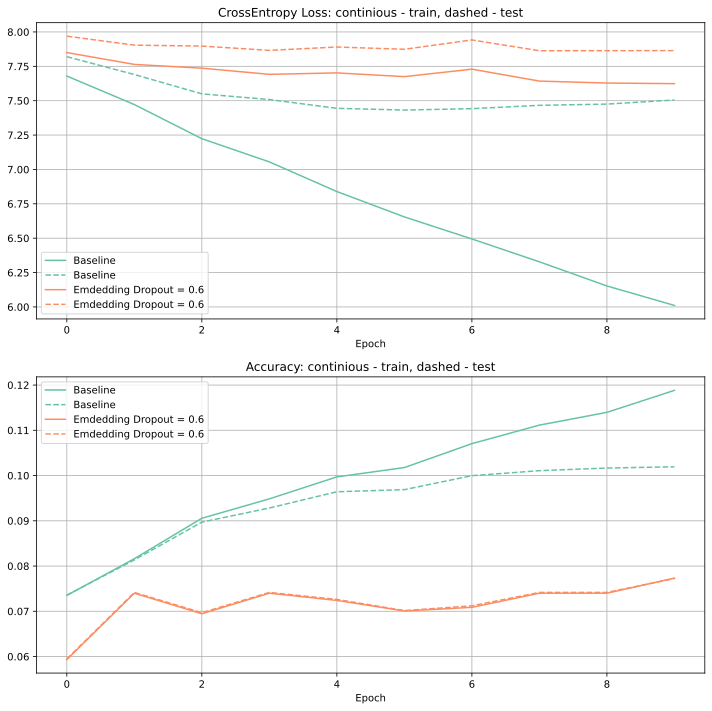

In [83]:
fig, axes = plt.subplots(2, 1, figsize=(10, 10))
x = np.arange(10)
for i, model in enumerate(lang_models_info):
    axes[0].plot(x, [y.cpu() for y in lang_models_info[model]['train_losses']], 
                 color=palette[i], label=labels[i])
    axes[0].plot(x, [y.cpu() for y in lang_models_info[model]['test_losses']], 
                 color=palette[i], label=labels[i], linestyle='--')
axes[0].legend()
axes[0].grid(True)
axes[0].set_xlabel('Epoch')
axes[0].set_title('CrossEntropy Loss: continious - train, dashed - test')

for i, model in enumerate(lang_models_info):
    axes[1].plot(x, [y.cpu() for y in lang_models_info[model]['train_accuracies']], 
                 color=palette[i], label=labels[i])
    axes[1].plot(x, [y.cpu() for y in lang_models_info[model]['test_accuracies']], 
                 color=palette[i], label=labels[i], linestyle='--')
axes[1].legend()
axes[1].grid(True)
axes[1].set_xlabel('Epoch')
axes[1].set_title('Accuracy: continious - train, dashed - test')

fig.tight_layout()
plt.show()

По времени модели приблизительно работают одинаково, однако на генерацию масок в embeddimg dropout уходит время( но у нас получалось крайне незначительное различие, которым можно пренебречь)

Baseline дал лучше качество на тестовой выборке 0.102 против 0.077. При этом переобучения в Embedding Dropout  еще меньше (фактически его нет).